In [ ]:
# in this notebook, I will try to fit a model relating the mean behavior of L4, L2/3, SST and VIP cells

In [ ]:
# load the data

In [1]:
import pyute as ut
import autograd.numpy as np
import matplotlib.pyplot as plt
import sklearn
import h5py
import pdb
import scipy.optimize as sop
from mpl_toolkits.mplot3d import Axes3D
import sklearn.discriminant_analysis as skd
import autograd.scipy.special as ssp
from autograd import elementwise_grad as egrad
from autograd import grad
from autograd import jacobian
from autograd import hessian
import size_contrast_analysis as sca
import scipy.stats as sst
import sim_utils
from importlib import reload
reload(sim_utils)
import calnet.utils
import calnet.fitting_spatial_feature_model
import opto_utils
%matplotlib notebook

/Users/dan/Documents/code/downloads/OASIS/oasis/functions.py:14: UserWarning: Could not find cvxpy. Don't worry, you can still use OASIS, just not the slower interior point methods we compared to in the papers.
  "just not the slower interior point methods we compared to in the papers.")


In [2]:
dsbase = '/Users/dan/Documents/notebooks/mossing-PC/shared_data/'
dsnames = [dsbase+x+'_data_struct.hdf5' for x in ['pyr_l4','pyr_l23','sst_l23','vip_l23','pv_l23']]
dsnames = [dsnames[3]]

In [3]:
nsize,ncontrast = 6,6

In [4]:
with ut.hdf5read(dsnames[0]) as ds:
    keylist = list(ds.keys())
    print(ds[keylist[0]].keys())

<KeysViewHDF5 ['cell_center', 'cell_depth', 'cell_id', 'cell_mask', 'cell_type', 'figure_ground_0', 'mouse_id', 'retinotopy_0']>


In [5]:
with ut.hdf5read(dsnames[0]) as ds:
    keylist = list(ds.keys())
    print(list(ds[keylist[3]].keys()))

['cell_center', 'cell_depth', 'cell_id', 'cell_mask', 'cell_type', 'figure_ground_0', 'mouse_id', 'retinotopy_0', 'size_contrast_0']


In [6]:
to_exclude = ['session_'+exptname for exptname in ['180714_M9053','180321_M7955', '180519_M8959', '180531_M8961', '180618_M8956','190202_M10075', '190620_M10619']]
tunings_ret,uparams_ret,displacements,pvals = [[None,None] for ivar in range(4)]
for irun,run_bool in enumerate([False,True]):
    tunings_ret[irun],uparams_ret[irun],displacements[irun],pvals[irun] = [[] for ivar in range(4)]
    for dsname in dsnames:
        new_vars = sim_utils.compute_tuning(dsname,datafield='decon',running=run_bool,expttype='retinotopy_0')
        tunings_ret[irun] = tunings_ret[irun] + [new_vars[0]]
        uparams_ret[irun] = uparams_ret[irun] + [new_vars[1]]
        displacements[irun] = displacements[irun] + [new_vars[2]]
        pvals[irun] = pvals[irun] + [new_vars[3]]


<HDF5 group "/session_180321_M7955" (8 members)>
decon
0.32222222222222224
<HDF5 group "/session_180412_M7955" (8 members)>
decon
0.0
<HDF5 group "/session_180516_M8956" (9 members)>
decon
0.07777777777777778
<HDF5 group "/session_180519_M8959" (9 members)>
decon
0.016666666666666666
<HDF5 group "/session_180528_M8959" (9 members)>
decon
0.3523809523809524
<HDF5 group "/session_180531_M8961" (9 members)>
decon
0.4266666666666667
<HDF5 group "/session_180618_M8956" (9 members)>
decon
0.06285714285714286
<HDF5 group "/session_180719_M8961" (8 members)>
decon
1.0
<HDF5 group "/session_180720_M8961" (8 members)>
decon
0.9629629629629629
<HDF5 group "/session_180903_M8961" (9 members)>
decon
0.09259259259259259
<HDF5 group "/session_190710_M0208" (13 members)>
decon
0.8189300411522634
<HDF5 group "/session_191215_M0385" (13 members)>
decon
1.0
<HDF5 group "/session_200103_M0388" (13 members)>
decon
0.9300411522633745
<HDF5 group "/session_180321_M7955" (8 members)>
decon
0.6777777777777778


In [7]:
# to_exclude = ['session_'+exptname for exptname in ['180714_M9053','180321_M7955', '180519_M8959', '180531_M8961', '180618_M8956','190202_M10075', '190620_M10619']]
# tunings_sc,uparams_sc,displacements,pvals = [[None,None] for ivar in range(4)]
# for irun,run_bool in enumerate([False,True]):
#     tunings_sc[irun],uparams_sc[irun],displacements[irun],pvals[irun] = [[] for ivar in range(4)]
#     for dsname in dsnames:
#         new_vars = sim_utils.compute_tuning(dsname,datafield='F',running=run_bool,expttype='size_contrast_0')
#         tunings_sc[irun] = tunings_sc[irun] + [new_vars[0]]
#         uparams_sc[irun] = uparams_sc[irun] + [new_vars[1]]
#         displacements[irun] = displacements[irun] + [new_vars[2]]
#         pvals[irun] = pvals[irun] + [new_vars[3]]


In [8]:
to_exclude = ['session_'+exptname for exptname in ['180714_M9053','180321_M7955', '180519_M8959', '180531_M8961', '180618_M8956','190202_M10075', '190620_M10619']]
tunings_decon,uparams_decon,displacements,pvals = [[None,None] for ivar in range(4)]
for irun,run_bool in enumerate([False,True]):
    tunings_decon[irun],uparams_decon[irun],displacements[irun],pvals[irun] = [[] for ivar in range(4)]
    for dsname in dsnames:
        new_vars = sim_utils.compute_tuning(dsname,datafield='decon',running=run_bool,expttype='size_contrast_0')
        tunings_decon[irun] = tunings_decon[irun] + [new_vars[0]]
        uparams_decon[irun] = uparams_decon[irun] + [new_vars[1]]
        displacements[irun] = displacements[irun] + [new_vars[2]]
        pvals[irun] = pvals[irun] + [new_vars[3]]


<HDF5 group "/session_180321_M7955" (8 members)>
<HDF5 group "/session_180412_M7955" (8 members)>
decon
0.011
<HDF5 group "/session_180516_M8956" (9 members)>
decon
0.275
<HDF5 group "/session_180519_M8959" (9 members)>
decon
0.0575
<HDF5 group "/session_180528_M8959" (9 members)>
decon
0.3383333333333333
<HDF5 group "/session_180531_M8961" (9 members)>
decon
0.3625
<HDF5 group "/session_180618_M8956" (9 members)>
decon
0.004166666666666667
<HDF5 group "/session_180719_M8961" (8 members)>
decon
0.9908333333333333
<HDF5 group "/session_180720_M8961" (8 members)>
decon
0.9541666666666667
<HDF5 group "/session_180903_M8961" (9 members)>
decon
0.16583333333333333
<HDF5 group "/session_190710_M0208" (13 members)>
decon
0.7237103174603174
<HDF5 group "/session_191215_M0385" (13 members)>
decon
0.8100198412698413
<HDF5 group "/session_200103_M0388" (13 members)>
decon
0.9191468253968254
<HDF5 group "/session_180321_M7955" (8 members)>
<HDF5 group "/session_180412_M7955" (8 members)>
decon
0.9

/Users/dan/Documents/code/adesnal/pyute.py:1199: RuntimeWarning: Mean of empty slice
  tuning[:,itype] = np.nanmean(data[cell_criteria][:,these_trials],1)


<HDF5 group "/session_180531_M8961" (9 members)>
decon
0.6375


/Users/dan/Documents/code/adesnal/pyute.py:1199: RuntimeWarning: Mean of empty slice
  tuning[:,itype] = np.nanmean(data[cell_criteria][:,these_trials],1)


<HDF5 group "/session_180618_M8956" (9 members)>
decon
0.9958333333333333
<HDF5 group "/session_180719_M8961" (8 members)>
decon
0.009166666666666667
<HDF5 group "/session_180720_M8961" (8 members)>
decon
0.04583333333333333
<HDF5 group "/session_180903_M8961" (9 members)>
decon
0.8341666666666666
<HDF5 group "/session_190710_M0208" (13 members)>
decon
0.27628968253968256
<HDF5 group "/session_191215_M0385" (13 members)>
decon
0.18998015873015872
<HDF5 group "/session_200103_M0388" (13 members)>
decon
0.08085317460317461


In [9]:
reload(sim_utils)
to_exclude = ['session_'+exptname for exptname in ['180714_M9053','180321_M7955', '180519_M8959', '180531_M8961', '180618_M8956','190202_M10075', '190620_M10619']]
ret_info,uparams_sc,displacements,pvals = [[None,None] for ivar in range(4)]
for irun,run_bool in enumerate([False,True]):
    ret_info[irun] = []
    for dsname in dsnames:
        new_vars = sim_utils.get_ret_info(dsname,expttype='size_contrast_0')
        ret_info[irun] = ret_info[irun] + [new_vars]

<HDF5 group "/session_180321_M7955" (8 members)>
<HDF5 group "/session_180412_M7955" (8 members)>
<HDF5 group "/session_180516_M8956" (9 members)>
<HDF5 group "/session_180519_M8959" (9 members)>
<HDF5 group "/session_180528_M8959" (9 members)>
<HDF5 group "/session_180531_M8961" (9 members)>
<HDF5 group "/session_180618_M8956" (9 members)>
<HDF5 group "/session_180719_M8961" (8 members)>
<HDF5 group "/session_180720_M8961" (8 members)>
<HDF5 group "/session_180903_M8961" (9 members)>
<HDF5 group "/session_190710_M0208" (13 members)>
<HDF5 group "/session_191215_M0385" (13 members)>
<HDF5 group "/session_200103_M0388" (13 members)>
<HDF5 group "/session_180321_M7955" (8 members)>
<HDF5 group "/session_180412_M7955" (8 members)>
<HDF5 group "/session_180516_M8956" (9 members)>
<HDF5 group "/session_180519_M8959" (9 members)>
<HDF5 group "/session_180528_M8959" (9 members)>
<HDF5 group "/session_180531_M8961" (9 members)>
<HDF5 group "/session_180618_M8956" (9 members)>
<HDF5 group "/ses

In [10]:
ut.imshow_in_rows(tunings_ret[0][0][-1][:100,:,:,8:-8].mean(-1))

TypeError: 'NoneType' object is not subscriptable

In [11]:
ut.imshow_in_rows(tunings_ret[0][2][8][:,:,:,8:-8].mean(-1))

IndexError: list index out of range

In [10]:
uangle = np.arange(0,360,45)
def nansem(data):
    return np.nanstd(data)/np.sqrt(np.sum(~np.isnan(data)))
def n_non_nan(data):
    return np.sum(~np.isnan(data))
def osi_after_nanmean(data):
    # nanmean along first axis, then compute osi along second axis
    return ut.compute_osi(np.nanmean(data,0)[:,np.newaxis],uangle)[0]

In [11]:
def von_mises_function(x,kappa,mu,ht):
    # x: directions in radians
    # kappa: tuning sharpness parameter
    # mu: preferred direction in radians
    # ht: height of non-preferred direction peak relative to preferred
    return (np.exp(kappa*np.cos(x-mu)) + ht*np.exp(kappa*np.cos(x-mu-np.pi)))/(np.exp(kappa) + ht*np.exp(-kappa))
def sym_von_mises_function(x,kappa,amplitude,offset=0):
    # constraining ht = 1 above
    # multiplies output of von_mises_function() by amplitude
    return amplitude*von_mises_function(x,kappa,0,1)+offset
def svm_fn(*args):#kappa,amplitude):
    # wrapper function, using fixed uangle in degrees
    return sym_von_mises_function(np.deg2rad(uangle),*args)#kappa,amplitude)
def svm_cost(x,data):
    # computes cost given parameters (kappa, amplitude[, optionally offset])
    return np.nansum((data-svm_fn(*x))**2)
def svm_cost_l1(x,data,lam=1):
    # computes cost given (kappa, amplitude[, optionally offset]), with an L1 penalty on kappa (exponential distribution prior on kappa)
    return np.nansum((data-svm_fn(*x))**2) + lam*x[0]
def optimize_kappa(data,x0=None,cost_fn=svm_cost,args=()):
    # given data, optimize (kappa, amplitude) inputs to svm_fn(), and return kappa
    if x0 is None:
        x0 = np.array((1,np.nanmax(data)))
    result = sop.minimize(cost_fn,x0,args=(data,)+args,bounds=[(0,np.inf),(0,np.inf)])
    kappa = result.x[0]
    return kappa
def optimize_kappa_offset(data,x0=None,cost_fn=svm_cost,args=()):
    # given data, optimize (kappa, amplitude) inputs to svm_fn(), and return kappa
    if x0 is None:
        x0 = np.array((1,np.nanmax(data),0))
    result = sop.minimize(cost_fn,x0,args=(data,)+args,bounds=[(0,np.inf),(0,np.inf),(-np.inf,np.inf)])
    kappa = result.x[0]
    return kappa

In [37]:
ncutoff = 10
nsize,ncontrast,nangle = 6,6,8
irun,itype,ialign = 0,0,0
nexpt = len(ret_info[0][0])
bins = np.linspace(0,30,6)
nbin = len(bins)-1
data_bin = np.nan*np.ones((nexpt,nbin,nsize,ncontrast))
data_sem = np.nan*np.ones((nexpt,nbin,nsize,ncontrast))
osi_bin = np.nan*np.ones((nexpt,nbin,nsize,ncontrast))
kappa_bin = np.nan*np.ones((nexpt,nbin,nsize,ncontrast))
# osi_sem = np.nan*np.ones((nexpt,nbin,nsize,ncontrast))
data_n = np.nan*np.ones((nexpt,nbin,nsize,ncontrast))
# pshift = np.nan*np.ones((nexpt,nbin-1,nsize,ncontrast))
l1_lambda = 5e-5
for iexpt in range(nexpt):
    if not ret_info[0][0][iexpt] is None and not ret_info[0][0][iexpt]['ret_map_loc'] is None and not tunings_decon[0][0][iexpt] is None:
#         distance = np.sqrt(np.sum(ret_info[0][0][iexpt]['ret_map_loc']**2,1))
        distance = np.sqrt(np.sum(ret_info[0][0][iexpt]['rf_center']**2,1))
        this_data = np.nanmean(tunings_decon[0][0][iexpt][:,:,[0,-5,-4,-3,-2,-1],:,8:-8],4)
        data = np.nanmean(this_data,3)
#         osi_data = ut.compute_osi(this_data[:,:,:,:,np.newaxis],np.arange(0,360,45))[:,:,:,0]
# 
#         data = np.nanmean(rs[irun][itype][ialign][(expt_ids[irun][itype][ialign]==iexpt)],3)
        data = data/np.nanmean(data)
        ori_data = ut.circ_align_to_pref(this_data,axis=3)
#         osi_data[np.isnan(osi_data)] = 0
#         ori_data[np.isnan(ori_data)] = 0
#         data = data/np.nanmean(np.nanmean(data,1),1)[:,np.newaxis,np.newaxis]
        non_nan = ~np.isnan(np.nanmean(np.nanmean(data,1),1)) #& ~np.isnan(np.nanmean(np.nanmean(np.nanmean(ori_data,1),1),1))
        sig_driven = (ret_info[0][0][iexpt]['pval'] < 0.05) #& (ret_info[0][0][iexpt]['amplitude'] > 0) & (ret_info[0][0][iexpt]['sigma'] > 3.3) & (ret_info[0][0][iexpt]['sqerror'] < 0.5)
        lkat = non_nan & sig_driven
        this_nsize = data.shape[1]
        if np.sum(lkat):
            for isize in range(this_nsize):
                for icontrast in range(ncontrast):
#                     for ibin in range(nbin-1):
#                         group1 = data[lkat,isize,icontrast][(distance[lkat]>bins[ibin]) & (distance[lkat]<=bins[ibin+1])]
#                         group2 = data[lkat,isize,icontrast][(distance[lkat]>bins[ibin+1]) & (distance[lkat]<=bins[ibin+2])]
#                         if group1.size and group2.size:  
#                             result = sst.mannwhitneyu(group1,group2)
#                             pshift[iexpt,ibin,isize,icontrast] = result.pvalue
                    data_bin[iexpt,:,isize,icontrast] = sst.binned_statistic(distance[lkat],data[lkat,isize,icontrast],statistic=np.nanmean,bins=bins).statistic
                    data_sem[iexpt,:,isize,icontrast] = sst.binned_statistic(distance[lkat],data[lkat,isize,icontrast],statistic=nansem,bins=bins).statistic
                    ori_data_bin = np.zeros((nangle,nbin))
                    for iangle in range(nangle):
                        this_lkat = ~np.isnan(ori_data[lkat,isize,icontrast,iangle])
                        this_ori_data = ori_data[lkat,isize,icontrast,iangle][this_lkat]
                        this_distance = distance[lkat][this_lkat]
                        ori_data_bin[iangle] = sst.binned_statistic(this_distance,this_ori_data,statistic=np.nanmean,bins=bins).statistic
                    osi_bin[iexpt,:,isize,icontrast] = ut.compute_osi(ori_data_bin,uangle)[0]
                    for ibin in range(nbin):
                        kappa_bin[iexpt,ibin,isize,icontrast] = optimize_kappa(ori_data_bin[:,ibin],cost_fn=svm_cost_l1,args=(l1_lambda,))
#                     osi_bin[iexpt,:,isize,icontrast] = sst.binned_statistic(distance[lkat],osi_data[lkat,isize,icontrast],statistic=np.nanmean,bins=bins).statistic
#                     osi_sem[iexpt,:,isize,icontrast] = sst.binned_statistic(distance[lkat],osi_data[lkat,isize,icontrast],statistic=nansem,bins=bins).statistic
                    data_n[iexpt,:,isize,icontrast] = sst.binned_statistic(distance[lkat],data[lkat,isize,icontrast],statistic=n_non_nan,bins=bins).statistic
data_bin[data_n < ncutoff] = np.nan
data_sem[data_n < ncutoff] = np.nan
osi_bin[data_n < ncutoff] = np.nan
kappa_bin[data_n < ncutoff] = np.nan
# osi_sem[data_n < 10] = np.nan
data_bin[:,:,:,:] = data_bin[:,:,:,:]-data_bin[:,:,:,0:1]
# data_sem[:,:,:,:] = data_sem[:,:,:,:]/np.nanmean(np.nanmean(np.nanmean(data_bin[:,:,:,:],2),2),0)[np.newaxis,:,np.newaxis,np.newaxis]
# data_bin[:,:,:,:] = data_bin[:,:,:,:]/np.nanmean(np.nanmean(np.nanmean(data_bin[:,:,:,:],2),2),0)[np.newaxis,:,np.newaxis,np.newaxis]

/Users/dan/Documents/code/adesnal/pyute.py:1940: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  data_aligned[iroi] = data[iroi][slicer]
/Users/dan/Documents/code/adesnal/pyute.py:1940: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  data_aligned[iroi] = data[iroi][slicer]
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: All-NaN slice encountered
  return f_raw(*args, **kwargs)
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: All-NaN slice encountered
  return

In [38]:
this_data = np.nanmean(ori_data,0)
this_data = ori_data[2]

In [25]:
kappa = np.zeros((nsize,ncontrast))
for isize in range(nsize):
    for icontrast in range(ncontrast):
        result = sop.minimize(svm_cost,np.array((1,1)),args=(this_data[isize,icontrast],),bounds=[(0,np.inf),(0,np.inf)])
        kappa[isize,icontrast] = result.x[0]
        

NameError: name 'this_data' is not defined

<IPython.core.display.Javascript object>


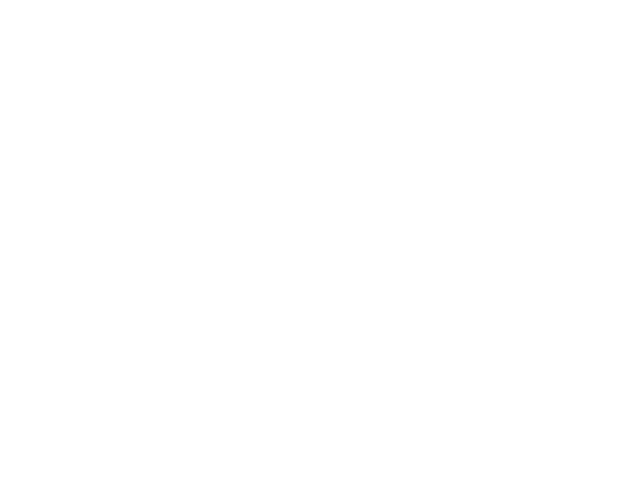

NameError: name 'this_data' is not defined

In [26]:
plt.figure()
plt.plot(this_data)
plt.plot(svm_fn(*result.x))

In [ ]:
fine_angles = np.arange(0,360,5)
plt.figure()
for kappa in [0,1,2,5,10]:
    plt.plot(fine_angles,sym_von_mises_function(np.deg2rad(fine_angles),kappa,1))

<IPython.core.display.Javascript object>


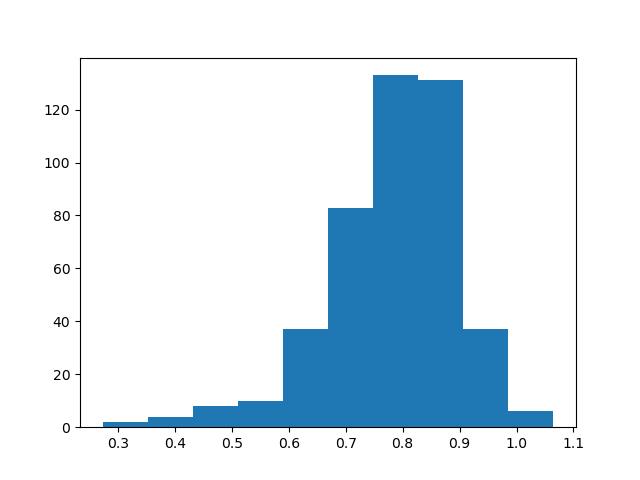

(array([  2.,   4.,   8.,  10.,  37.,  83., 133., 131.,  37.,   6.]),
 array([0.27295829, 0.35214421, 0.43133013, 0.51051605, 0.58970197,
        0.66888789, 0.74807381, 0.82725973, 0.90644565, 0.98563157,
        1.06481749]),
 <a list of 10 Patch objects>)

In [27]:
plt.figure()
plt.hist(ret_info[0][0][iexpt]['sqerror'])

In [ ]:
nsize,ncontrast = 6,6
pshift = np.nan*np.ones((nbin-1,nsize,ncontrast))
for isize in range(nsize):
    for icontrast in range(ncontrast):
        for ibin in range(nbin-1):
            lkat1 = ~np.isnan(data_bin[:,ibin,isize,icontrast]) 
            lkat2 = ~np.isnan(data_bin[:,ibin+1,isize,icontrast])
            lkat = lkat1 & lkat2
#             result = sst.wilcoxon(data_bin[:,ibin,isize,icontrast],data_bin[:,ibin+1,isize,icontrast])
            if lkat1.sum() and lkat2.sum() and (np.max(data_bin[lkat1,ibin,isize,icontrast])>0) and (np.max(data_bin[lkat2,ibin+1,isize,icontrast])>0):
                result = sst.wilcoxon(data_bin[lkat,ibin,isize,icontrast],data_bin[lkat,ibin+1,isize,icontrast])
                pshift[ibin,isize,icontrast] = result.pvalue

<IPython.core.display.Javascript object>


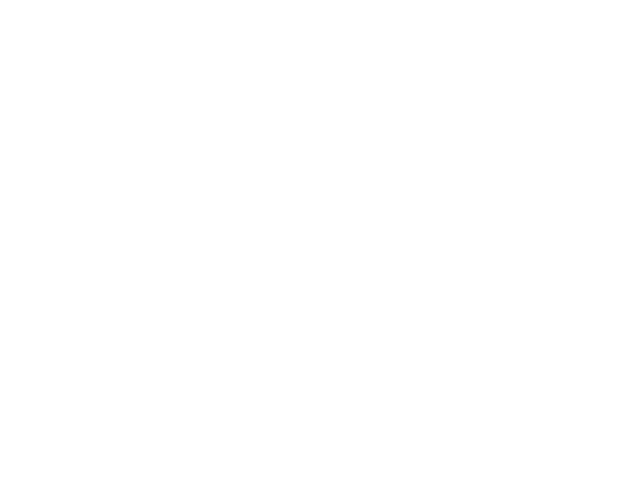

NameError: name 'pshift' is not defined

In [28]:
for ibin in range(4):
    plt.figure()
    plt.imshow((pshift[ibin]<0.05).astype('float'))
    plt.colorbar()

/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


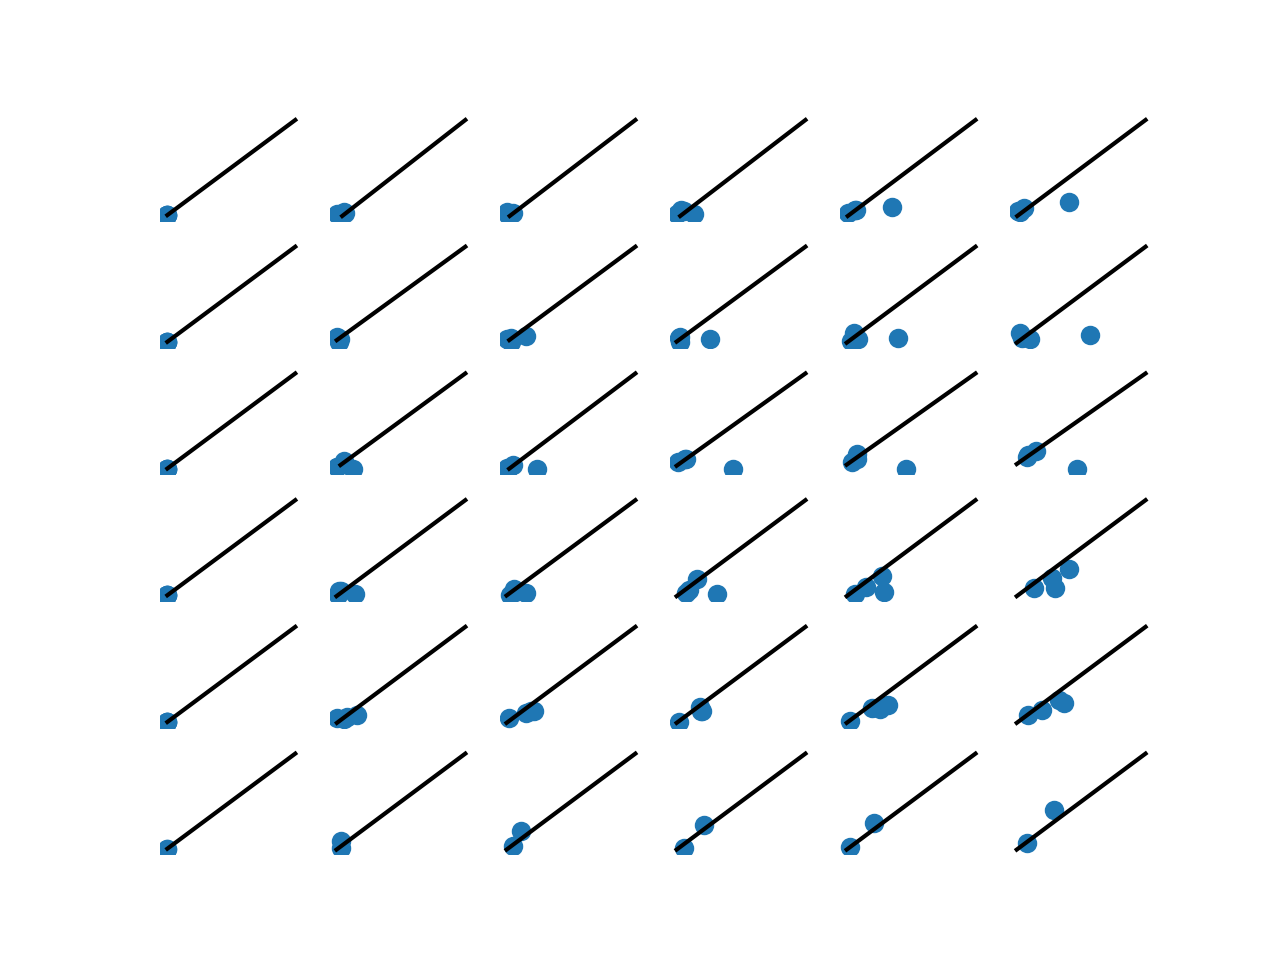

In [117]:
plt.figure()
for isize in range(nsize):
    for icontrast in range(ncontrast):
        plt.subplot(nsize,ncontrast,isize*ncontrast+icontrast+1)
        plt.scatter(data_bin[:,nbin-2,isize,icontrast],data_bin[:,nbin-1,isize,icontrast])
        xmax = 6
        plt.plot((0,xmax),(0,xmax),c='k')
        plt.axis('off')

<IPython.core.display.Javascript object>


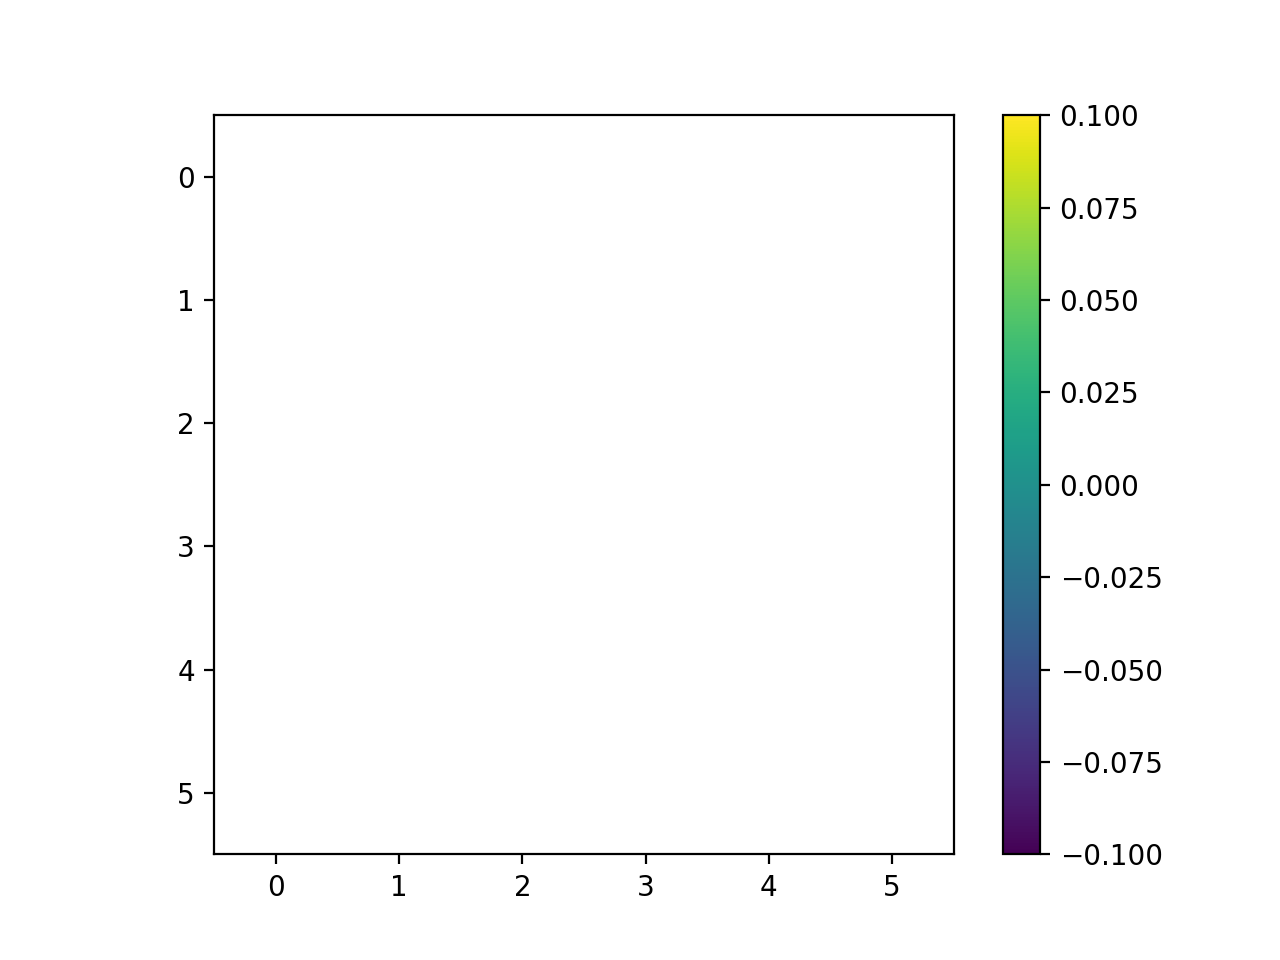

In [106]:
plt.figure()
plt.imshow(-np.log10(pshift[0,:,:]))
plt.colorbar()

In [94]:
data_bin[:,ibin,isize,icontrast]

array([       nan,        nan,        nan,        nan,        nan,
       1.7149815 ,        nan, 1.28743112, 0.49810651,        nan,
       0.94046867, 0.63712575, 0.10546067])

In [119]:
pshift

array([[[       nan,        nan,        nan,        nan,        nan,
                nan],
        [       nan,        nan,        nan,        nan,        nan,
                nan],
        [       nan,        nan,        nan,        nan,        nan,
                nan],
        [       nan,        nan,        nan,        nan,        nan,
                nan],
        [       nan,        nan,        nan,        nan,        nan,
                nan],
        [       nan,        nan,        nan,        nan,        nan,
                nan]],

       [[       nan, 0.39554076, 0.07885219, 0.02602938, 0.00309666,
         0.00522214],
        [       nan, 0.21338837, 0.05598068, 0.01084206, 0.00670933,
         0.00855912],
        [       nan, 0.32942163, 0.14465742, 0.03184489, 0.03184489,
         0.02602938],
        [       nan, 0.5       , 0.16569355, 0.18861231, 0.29812082,
         0.5       ],
        [       nan, 0.14465742, 0.4299096 , 0.32942163, 0.46481826,
         0.29812082

In [118]:
pshift[ibin,isize,icontrast]

0.43381616738909634

In [91]:
data_bin

array([[[[            nan,             nan,             nan,
                      nan,             nan,             nan],
         [            nan,             nan,             nan,
                      nan,             nan,             nan],
         [            nan,             nan,             nan,
                      nan,             nan,             nan],
         [            nan,             nan,             nan,
                      nan,             nan,             nan],
         [            nan,             nan,             nan,
                      nan,             nan,             nan],
         [            nan,             nan,             nan,
                      nan,             nan,             nan]],

        [[            nan,             nan,             nan,
                      nan,             nan,             nan],
         [            nan,             nan,             nan,
                      nan,             nan,             nan],
         [    

<IPython.core.display.Javascript object>


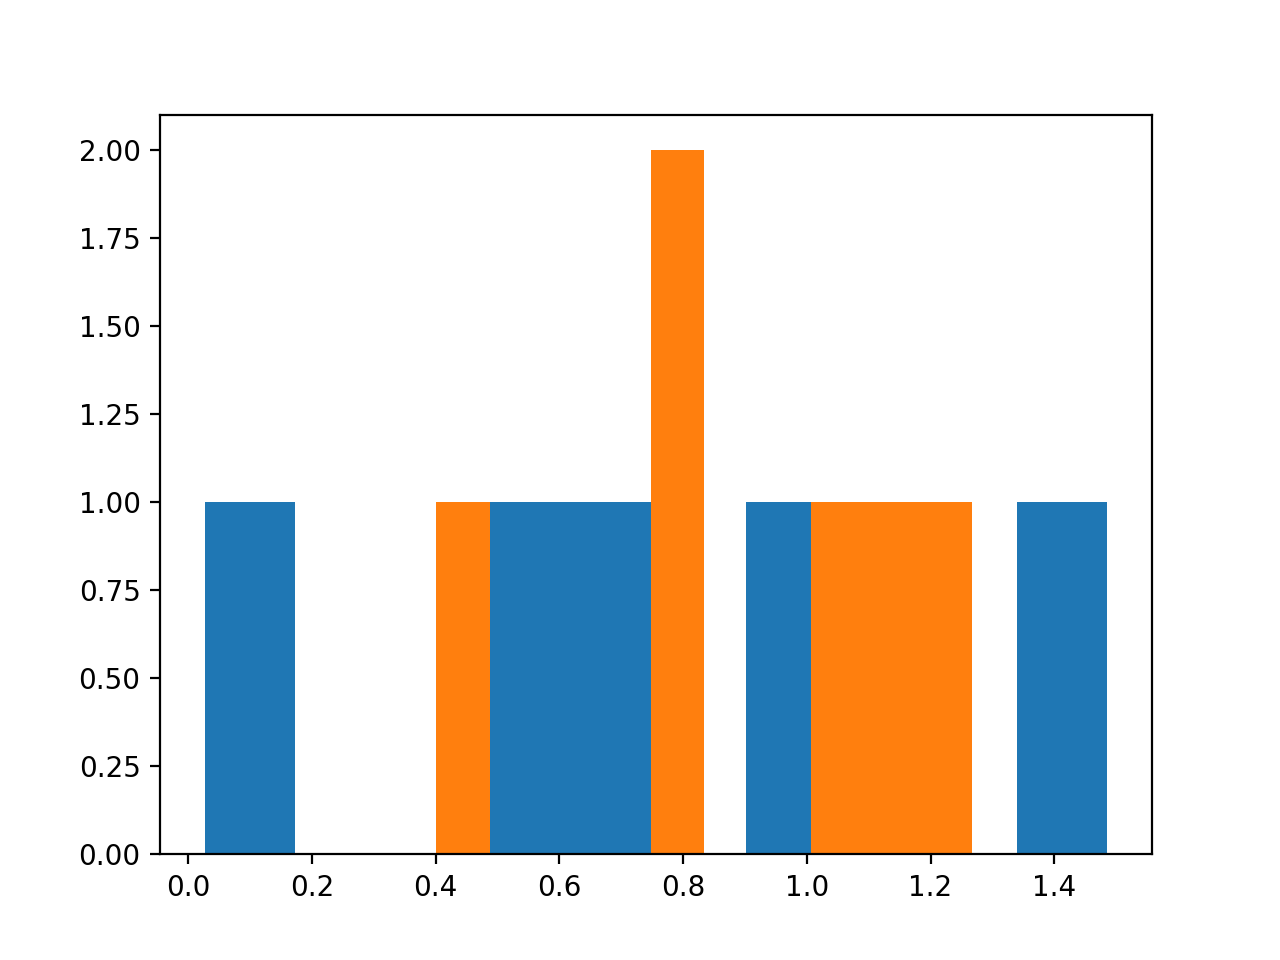

/opt/anaconda3/envs/py3/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([1., 0., 0., 0., 2., 0., 0., 1., 1., 1.]),
 array([0.40120393, 0.48775741, 0.5743109 , 0.66086439, 0.74741788,
        0.83397136, 0.92052485, 1.00707834, 1.09363183, 1.18018531,
        1.2667388 ]),
 <a list of 10 Patch objects>)

In [84]:
plt.figure()
plt.hist(data_bin[:,0,5,5])
plt.hist(data_bin[:,1,5,5])

In [85]:
data_bin[:,1,5,5]

array([       nan,        nan,        nan,        nan,        nan,
       1.2667388 ,        nan, 1.0947653 , 0.81165134,        nan,
       0.40120393, 0.8064941 , 1.00768773])

In [82]:
pshift[:,5,0]

array([0.01171869, 0.01796048, 0.01796048, 0.00334562])

In [34]:
usize = np.array((5,8,13,22,36,60))
ucontrast = np.array((0,6,12,25,50,100))

<IPython.core.display.Javascript object>


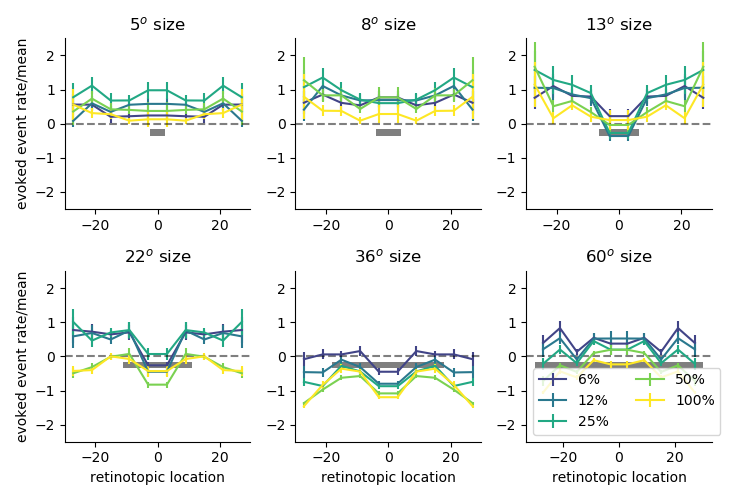

/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the 

In [43]:
colors = plt.cm.viridis(np.linspace(0,1,6))
x = 0.5*(bins[1:]+bins[:-1])
x = np.concatenate((-x[::-1],x))
plt.figure(figsize=(7.5,5))
for isize in range(nsize):
    plt.subplot(2,3,isize+1)
    for icontrast in range(1,ncontrast):
        lkat = data_n[:,:,isize,icontrast]
        data = np.nanmean(data_bin[:,:,isize,icontrast],0)
        data = np.concatenate((data[::-1],data))
        this_sem = np.sqrt(np.nansum(data_sem[:,:,isize,icontrast]**2,0))/np.sum(~np.isnan(data_sem[:,:,isize,icontrast]),0)
        this_sem = np.concatenate((this_sem[::-1],this_sem))
        plt.errorbar(x,data,this_sem,c=colors[icontrast],label='%d%%'%ucontrast[icontrast])
#     plt.ylim((0,6))
    plt.ylim((-2.5,2.5))
    plt.fill_between((-usize[isize]/2,usize[isize]/2),(-0.35,-0.35),(-0.15,-0.15),facecolor='k',alpha=0.5)
    ut.erase_top_right()
    plt.title('%d$^o$ size'%usize[isize])
    plt.axhline(0,c='k',linestyle='dashed',alpha=0.5)
for iplot in range(3,6):
    plt.subplot(2,3,iplot+1)
    plt.xlabel('retinotopic location')
for iplot in range(0,6,3):
    plt.subplot(2,3,iplot+1)
    plt.ylabel('evoked event rate/mean')
plt.subplot(2,3,6)
plt.legend(ncol=2)
plt.tight_layout()
plt.savefig('figures/spatial_evoked_by_size_vip.jpg',dpi=300)

<IPython.core.display.Javascript object>


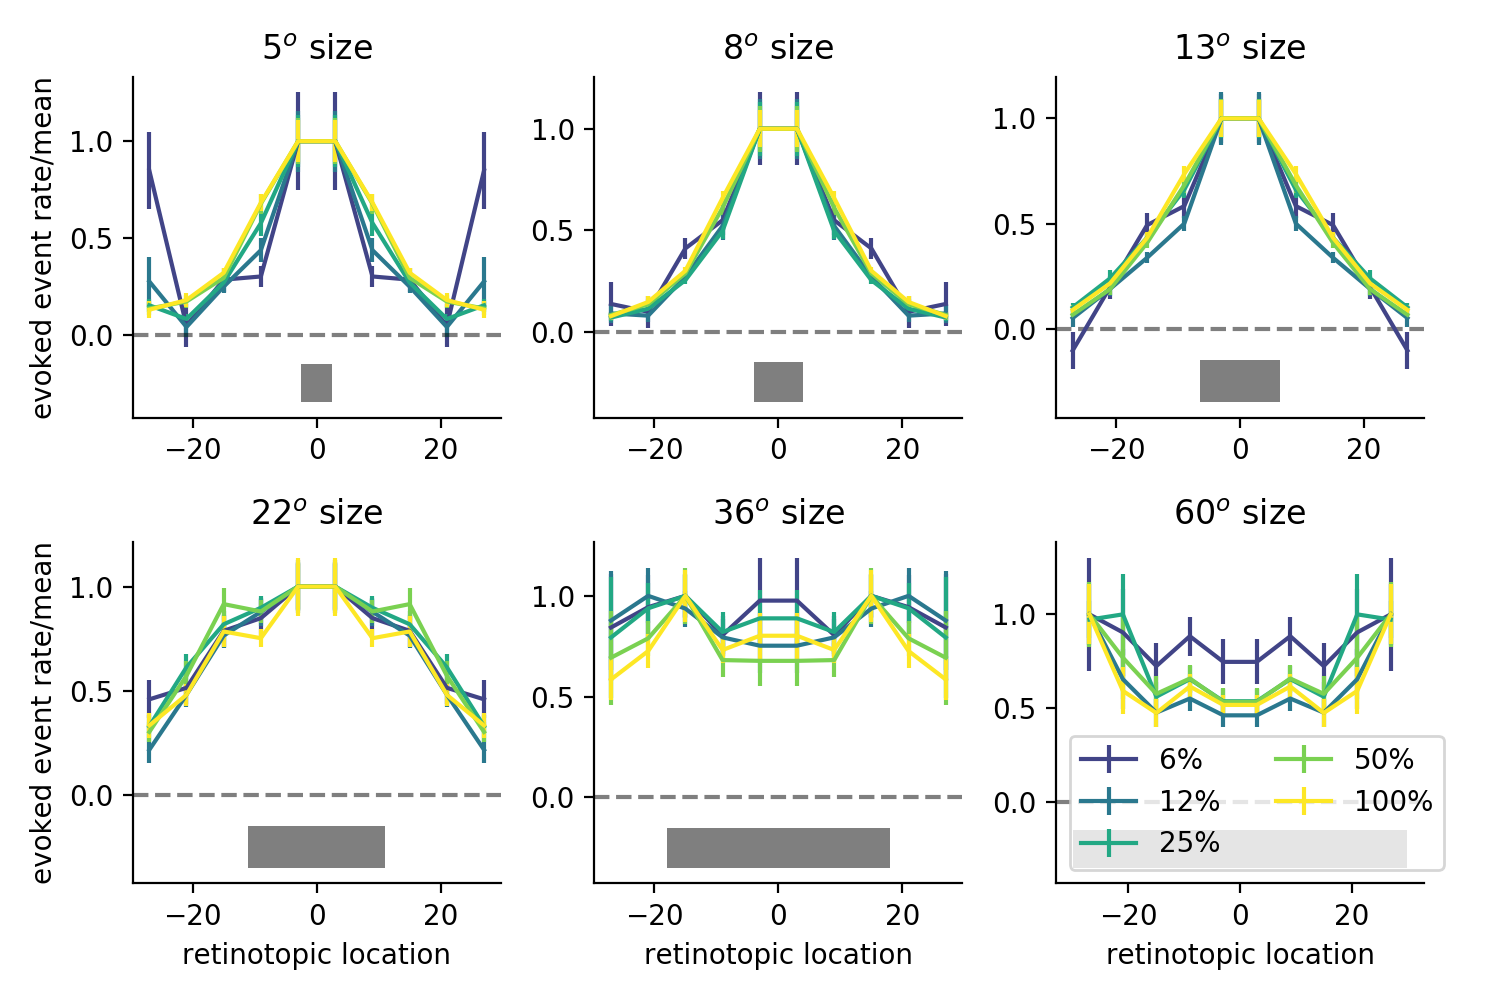

/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the 

In [45]:
colors = plt.cm.viridis(np.linspace(0,1,6))
x = 0.5*(bins[1:]+bins[:-1])
x = np.concatenate((-x[::-1],x))
plt.figure(figsize=(7.5,5))
for isize in range(nsize):
    plt.subplot(2,3,isize+1)
    for icontrast in range(1,ncontrast):
        lkat = data_n[:,:,isize,icontrast]
        data = np.nanmean(data_bin[:,:,isize,icontrast],0)
        data = np.concatenate((data[::-1],data))
        this_sem = np.sqrt(np.nansum(data_sem[:,:,isize,icontrast]**2,0))/np.sum(~np.isnan(data_sem[:,:,isize,icontrast]),0)
        this_sem = np.concatenate((this_sem[::-1],this_sem))
        plt.errorbar(x,data/data.max(),this_sem/data.max(),c=colors[icontrast],label='%d%%'%ucontrast[icontrast])
#     plt.ylim((-0.5,6))
    plt.fill_between((-usize[isize]/2,usize[isize]/2),(-0.35,-0.35),(-0.15,-0.15),facecolor='k',alpha=0.5)
    ut.erase_top_right()
    plt.title('%d$^o$ size'%usize[isize])
    plt.axhline(0,c='k',linestyle='dashed',alpha=0.5)
for iplot in range(3,6):
    plt.subplot(2,3,iplot+1)
    plt.xlabel('retinotopic location')
for iplot in range(0,6,3):
    plt.subplot(2,3,iplot+1)
    plt.ylabel('evoked event rate/mean')
plt.subplot(2,3,6)
plt.legend(ncol=2)
plt.tight_layout()
# plt.savefig('figures/spatial_evoked_by_size.jpg',dpi=300)

<IPython.core.display.Javascript object>


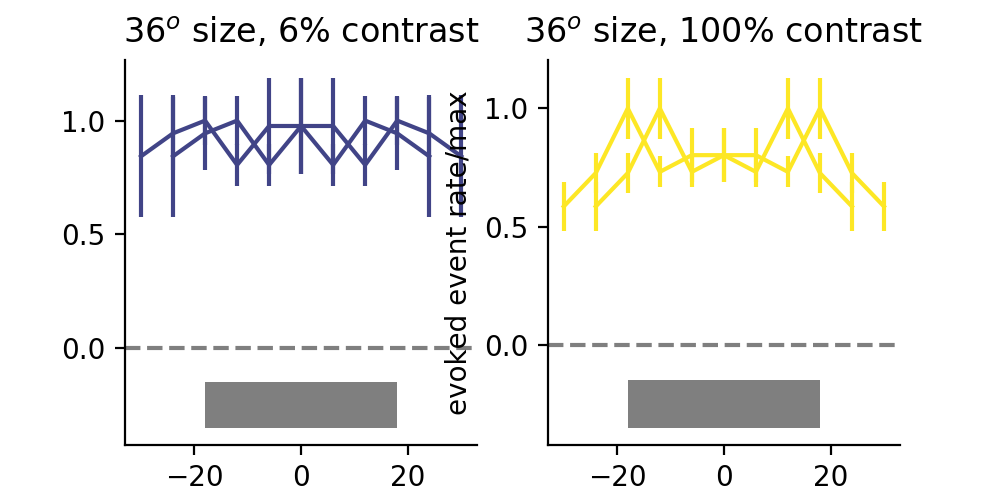

<IPython.core.display.Javascript object>


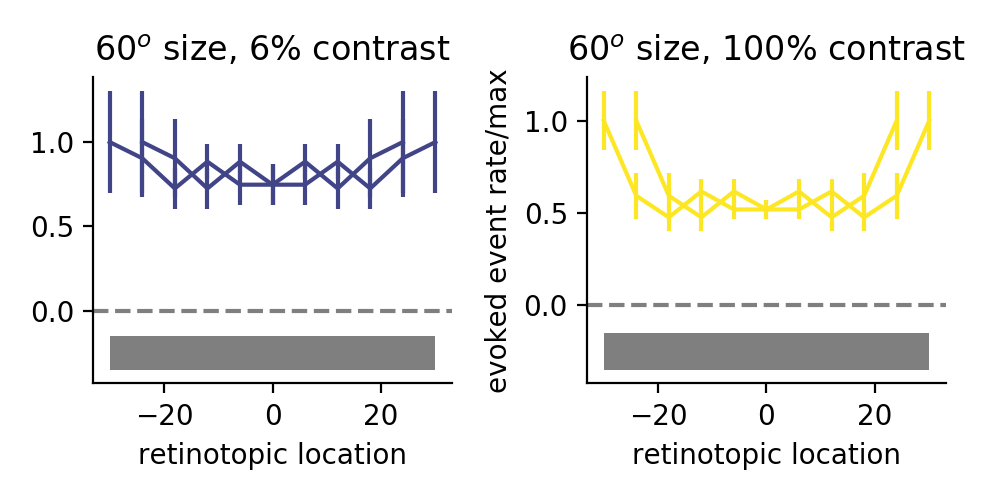

In [75]:
colors = plt.cm.viridis(np.linspace(0,1,6))
x = 0.5*(bins[1:]+bins[:-1])
x = np.concatenate((-x[::-1],x))
for isize in range(4,6):
    plt.figure(figsize=(5,2.5))
#     plt.subplot(2,3,isize+1)
    for iicontrast,icontrast in enumerate([1,5]):
        plt.subplot(1,2,iicontrast+1)
        lkat = data_n[:,:,isize,icontrast]
        data = np.nanmean(data_bin[:,:,isize,icontrast],0)
        data = np.concatenate((data[::-1],data))
        this_sem = np.sqrt(np.nansum(data_sem[:,:,isize,icontrast]**2,0))/np.sum(~np.isnan(data_sem[:,:,isize,icontrast]),0)
        this_sem = np.concatenate((this_sem[::-1],this_sem))
        plt.errorbar(x-3,data/data.max(),this_sem/data.max(),c=colors[icontrast],label='%d%%'%ucontrast[icontrast])
        plt.errorbar(x+3,data/data.max(),this_sem/data.max(),c=colors[icontrast],label='%d%%'%ucontrast[icontrast])
#         plt.fill_between(x[1:]-3,data[1:]/data.max(),data[:-1]/data.max(),facecolor='k',alpha=0.5)
#     plt.ylim((-0.5,6))
        plt.fill_between((-usize[isize]/2,usize[isize]/2),(-0.35,-0.35),(-0.15,-0.15),facecolor='k',alpha=0.5)
        ut.erase_top_right()
        plt.title('%d$^o$ size, %d%% contrast'%(usize[isize],ucontrast[icontrast]))
        plt.axhline(0,c='k',linestyle='dashed',alpha=0.5)
# for iplot in range(3,6):
#     plt.subplot(2,3,iplot+1)
        plt.xlabel('retinotopic location')
# for iplot in range(0,6,3):
#     plt.subplot(2,3,iplot+1)
    plt.ylabel('evoked event rate/max')
# plt.subplot(2,3,6)
# plt.legend()#ncol=2)
plt.tight_layout()
# plt.savefig('figures/spatial_evoked_by_size.jpg',dpi=300)

In [ ]:
colors = plt.cm.viridis(np.linspace(0,1,6))
x = 0.5*(bins[1:]+bins[:-1])
x = np.concatenate((-x[::-1],x))
plt.figure(figsize=(7.5,5))
for isize in range(nsize):
    plt.subplot(2,3,isize+1)
    for icontrast in range(1,ncontrast):
        lkat = data_n[:,:,isize,icontrast]
        data = np.nanmean(data_bin[:,:,isize,icontrast],0)
        data = np.concatenate((data[::-1],data))
        this_sem = np.sqrt(np.nansum(data_sem[:,:,isize,icontrast]**2,0))/np.sum(~np.isnan(data_sem[:,:,isize,icontrast]),0)
        this_sem = np.concatenate((this_sem[::-1],this_sem))
        plt.errorbar(x,data,this_sem,c=colors[icontrast],label='%d%%'%ucontrast[icontrast])
#     plt.ylim((-0.5,6))
    plt.fill_between((-usize[isize]/2,usize[isize]/2),(-0.35,-0.35),(-0.15,-0.15),facecolor='k',alpha=0.5)
    ut.erase_top_right()
    plt.title('%d$^o$ size'%usize[isize])
    plt.axhline(0,c='k',linestyle='dashed',alpha=0.5)
for iplot in range(3,6):
    plt.subplot(2,3,iplot+1)
    plt.xlabel('retinotopic location')
for iplot in range(0,6,3):
    plt.subplot(2,3,iplot+1)
    plt.ylabel('evoked event rate/mean')
plt.subplot(2,3,6)
# plt.legend(ncol=2)
plt.tight_layout()
# plt.savefig('figures/spatial_evoked_by_size_diff_y.jpg',dpi=300)

<IPython.core.display.Javascript object>


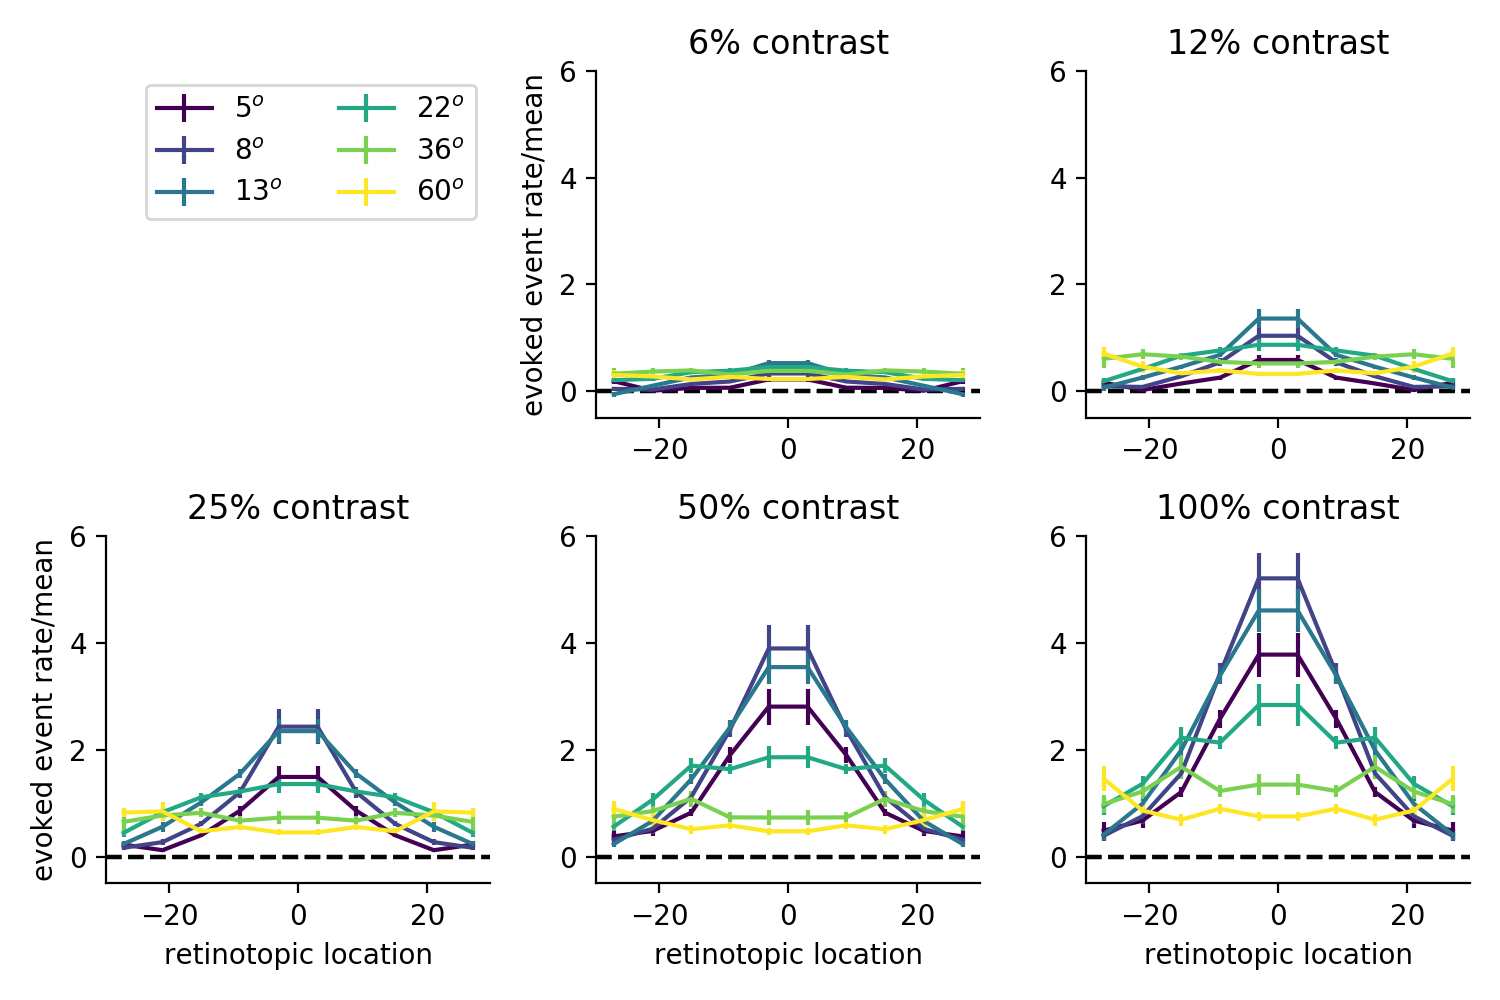

/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently

In [24]:
colors = plt.cm.viridis(np.linspace(0,1,6))
x = 0.5*(bins[1:]+bins[:-1])
x = np.concatenate((-x[::-1],x))
plt.figure(figsize=(7.5,5))
for isize in range(nsize):
    for icontrast in range(0,ncontrast):
        plt.subplot(2,3,icontrast+1)
        lkat = data_n[:,:,isize,icontrast]
        data = np.nanmean(data_bin[:,:,isize,icontrast],0)
        data = np.concatenate((data[::-1],data))
        this_sem = np.sqrt(np.nansum(data_sem[:,:,isize,icontrast]**2,0))/np.sum(~np.isnan(data_sem[:,:,isize,icontrast]),0)
        this_sem = np.concatenate((this_sem[::-1],this_sem))
        plt.errorbar(x,data,this_sem,c=colors[isize],label='%d$^o$'%usize[isize])
        plt.ylim((-0.5,6))
        ut.erase_top_right()
        if icontrast>0:
            plt.title('%d%% contrast'%ucontrast[icontrast])
            plt.axhline(0,c='k',linestyle='dashed',alpha=0.5)
#     plt.fill_between((-usize[isize]/2,usize[isize]/2),(-0.35,-0.35),(-0.15,-0.15),facecolor='k',alpha=0.5)
for iplot in range(3,6):
    plt.subplot(2,3,iplot+1)
    plt.xlabel('retinotopic location')
for iplot in [1,3]:
    plt.subplot(2,3,iplot+1)
    plt.ylabel('evoked event rate/mean')
plt.subplot(2,3,1)
plt.legend(ncol=2)
plt.axis('off')
plt.ylim((0.1,0.2))
plt.tight_layout()
# plt.savefig('figures/spatial_evoked_by_contrast.jpg',dpi=300)

<IPython.core.display.Javascript object>


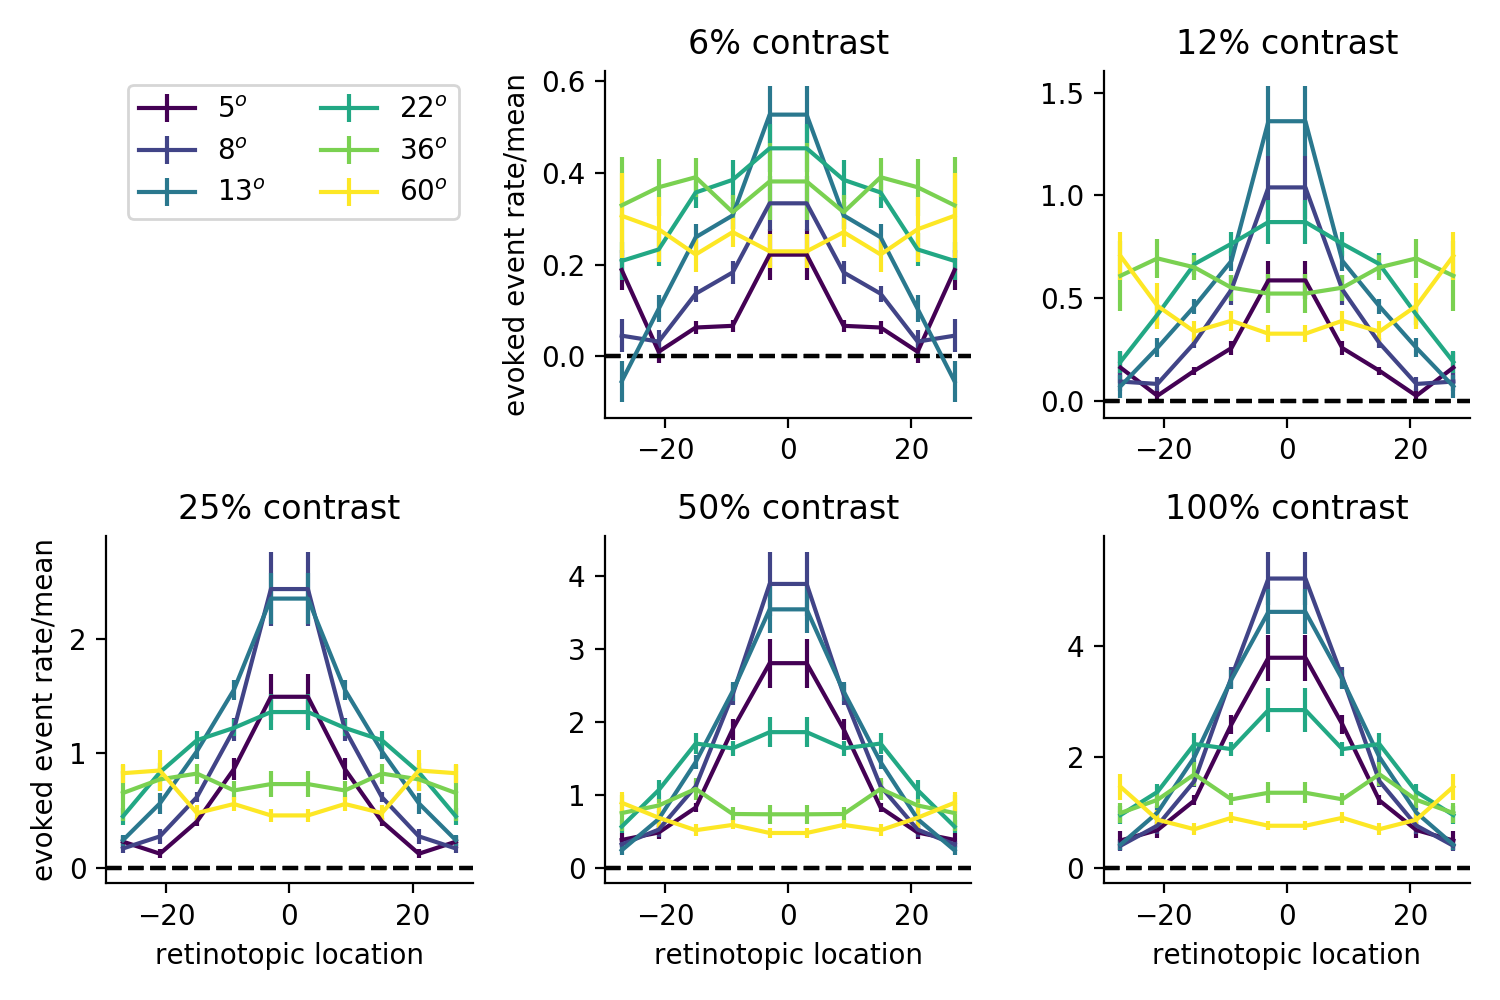

/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently

In [25]:
colors = plt.cm.viridis(np.linspace(0,1,6))
x = 0.5*(bins[1:]+bins[:-1])
x = np.concatenate((-x[::-1],x))
plt.figure(figsize=(7.5,5))
for isize in range(nsize):
    for icontrast in range(0,ncontrast):
        plt.subplot(2,3,icontrast+1)
        lkat = data_n[:,:,isize,icontrast]
        data = np.nanmean(data_bin[:,:,isize,icontrast],0)
        data = np.concatenate((data[::-1],data))
        this_sem = np.sqrt(np.nansum(data_sem[:,:,isize,icontrast]**2,0))/np.sum(~np.isnan(data_sem[:,:,isize,icontrast]),0)
        this_sem = np.concatenate((this_sem[::-1],this_sem))
        plt.errorbar(x,data,this_sem,c=colors[isize],label='%d$^o$'%usize[isize])
#         plt.ylim((-0.5,6))
        ut.erase_top_right()
        if icontrast>0:
            plt.title('%d%% contrast'%ucontrast[icontrast])
            plt.axhline(0,c='k',linestyle='dashed',alpha=0.5)
#     plt.fill_between((-usize[isize]/2,usize[isize]/2),(-0.35,-0.35),(-0.15,-0.15),facecolor='k',alpha=0.5)
for iplot in range(3,6):
    plt.subplot(2,3,iplot+1)
    plt.xlabel('retinotopic location')
for iplot in [1,3]:
    plt.subplot(2,3,iplot+1)
    plt.ylabel('evoked event rate/mean')
plt.subplot(2,3,1)
plt.legend(ncol=2)
plt.axis('off')
plt.ylim((0.1,0.2))
plt.tight_layout()
# plt.savefig('figures/spatial_evoked_by_contrast_diff_y.jpg',dpi=300)

<IPython.core.display.Javascript object>


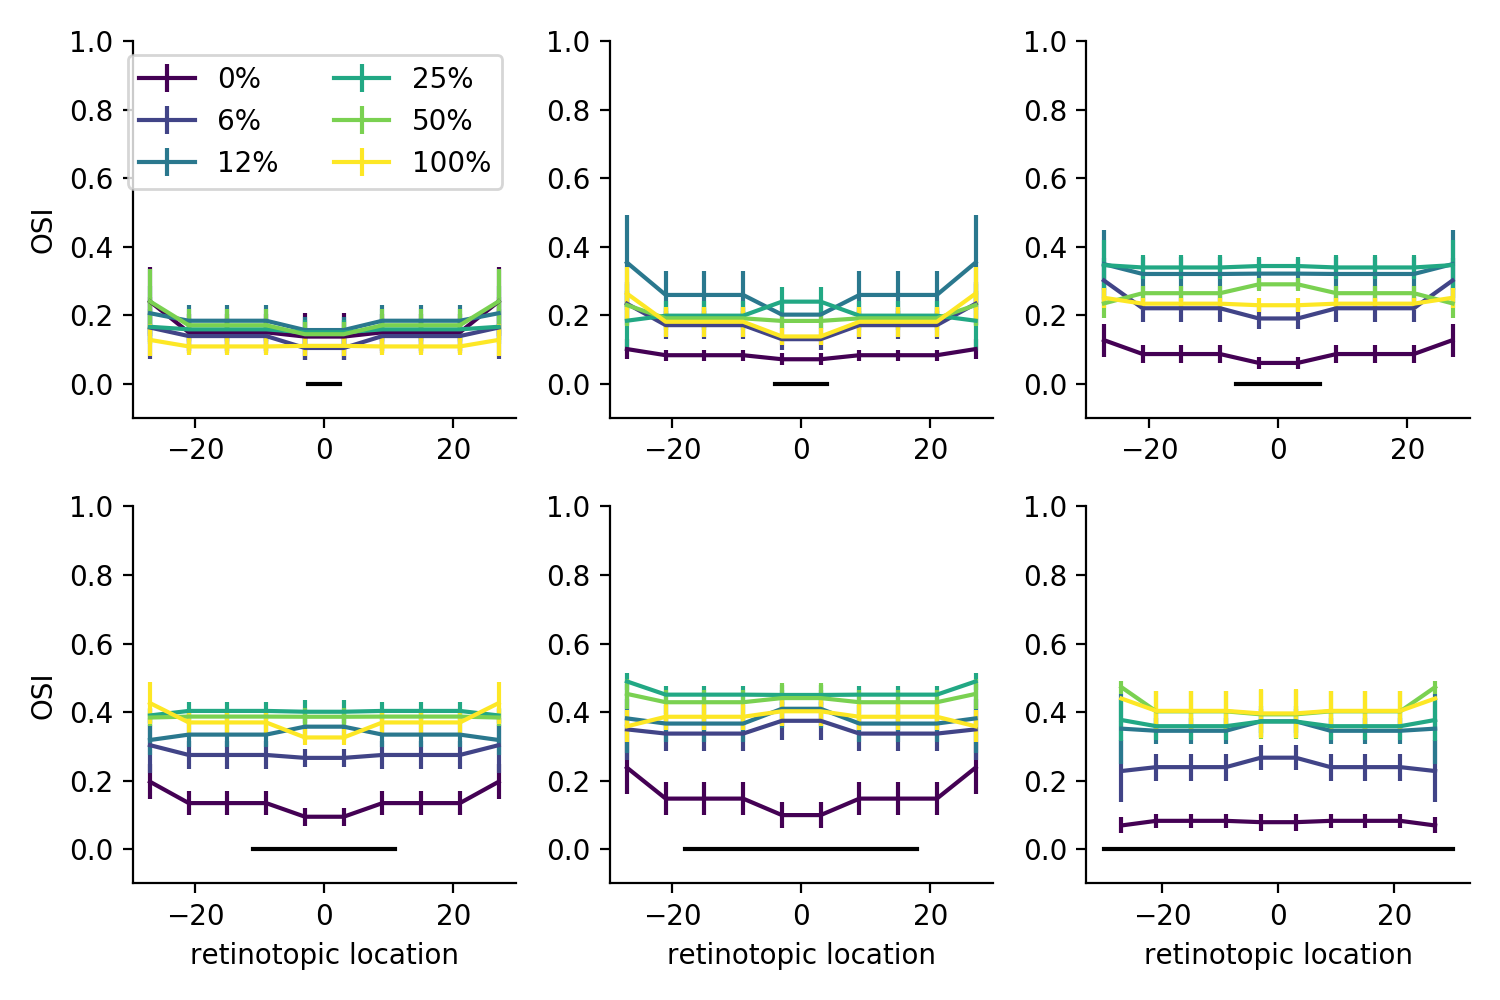

/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the 

In [26]:
colors = plt.cm.viridis(np.linspace(0,1,6))
x = 0.5*(bins[1:]+bins[:-1])
x = np.concatenate((-x[::-1],x))
plt.figure(figsize=(7.5,5))
for isize in range(nsize):
    plt.subplot(2,3,isize+1)
    for icontrast in range(0,ncontrast):
        lkat = data_n[:,:,isize,icontrast]
        data = np.nanmean(osi_bin[:,:,isize,icontrast],0)
        data = np.concatenate((data[::-1],data))
        this_sem = np.nanstd(osi_bin[:,:,isize,icontrast],0)/np.sqrt(np.sum(~np.isnan(osi_bin[:,:,isize,icontrast]),0))
#         this_sem = np.sqrt(np.nansum(osi_sem[:,:,isize,icontrast]**2,0))/np.sum(~np.isnan(data_sem[:,:,isize,icontrast]),0)
        this_sem = np.concatenate((this_sem[::-1],this_sem))
        plt.errorbar(x,data,this_sem,c=colors[icontrast],label='%d%%'%ucontrast[icontrast])
#         plt.plot(x,data,c=colors[icontrast])
    plt.ylim((-0.1,1))
    plt.plot((-usize[isize]/2,usize[isize]/2),(0,0),c='k')
    ut.erase_top_right()
for iplot in range(3,6):
    plt.subplot(2,3,iplot+1)
    plt.xlabel('retinotopic location')
for iplot in range(0,6,3):
    plt.subplot(2,3,iplot+1)
    plt.ylabel('OSI')
plt.subplot(2,3,1)
plt.legend(ncol=2)
plt.tight_layout()

<IPython.core.display.Javascript object>


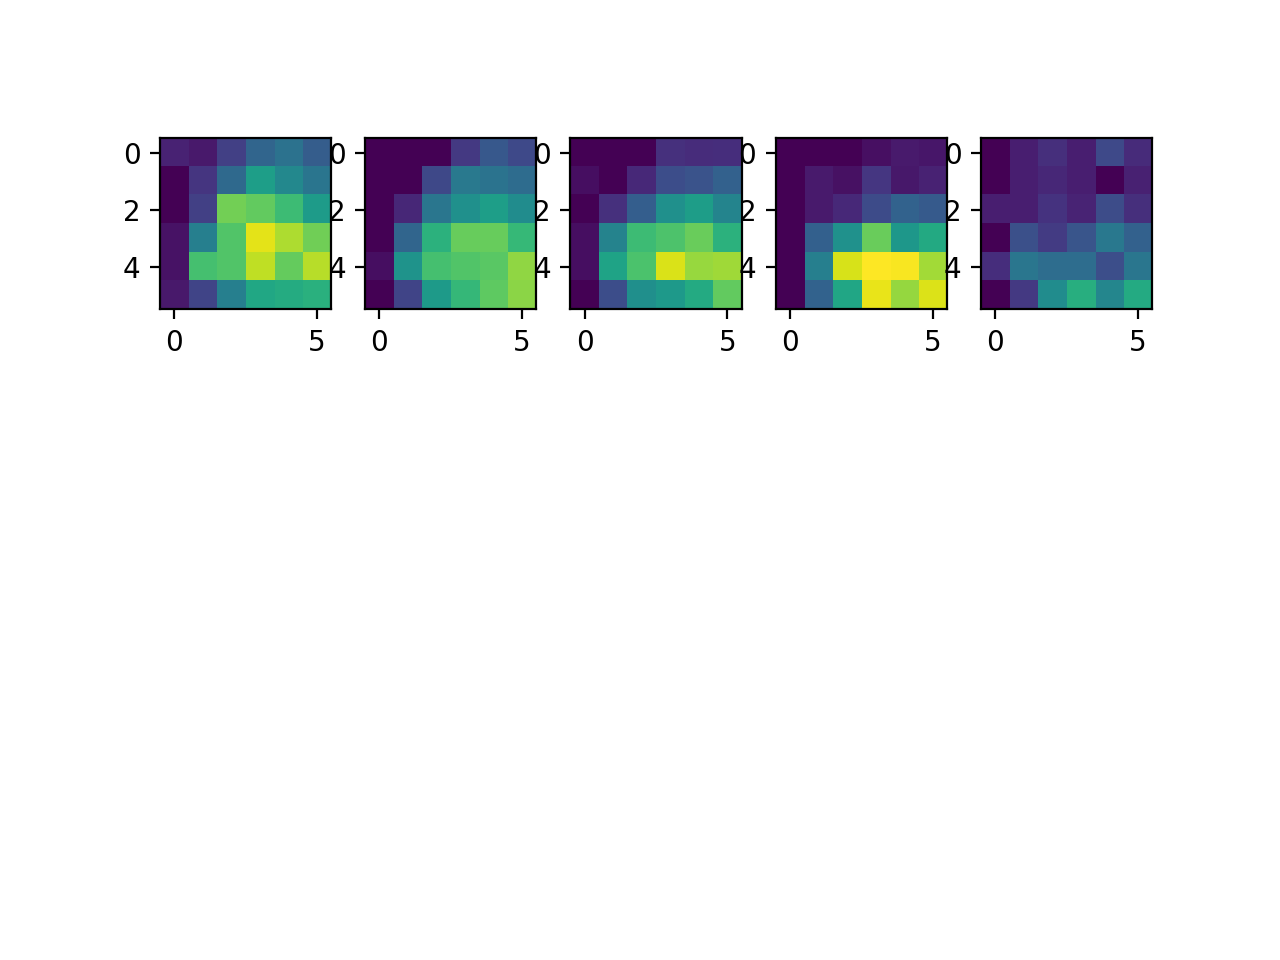

In [27]:
plt.figure()
for ibin in range(nbin):
    plt.subplot(3,5,ibin+1)
    plt.imshow(np.nanmean(kappa_bin,0)[ibin],vmin=0,vmax=3)

<IPython.core.display.Javascript object>


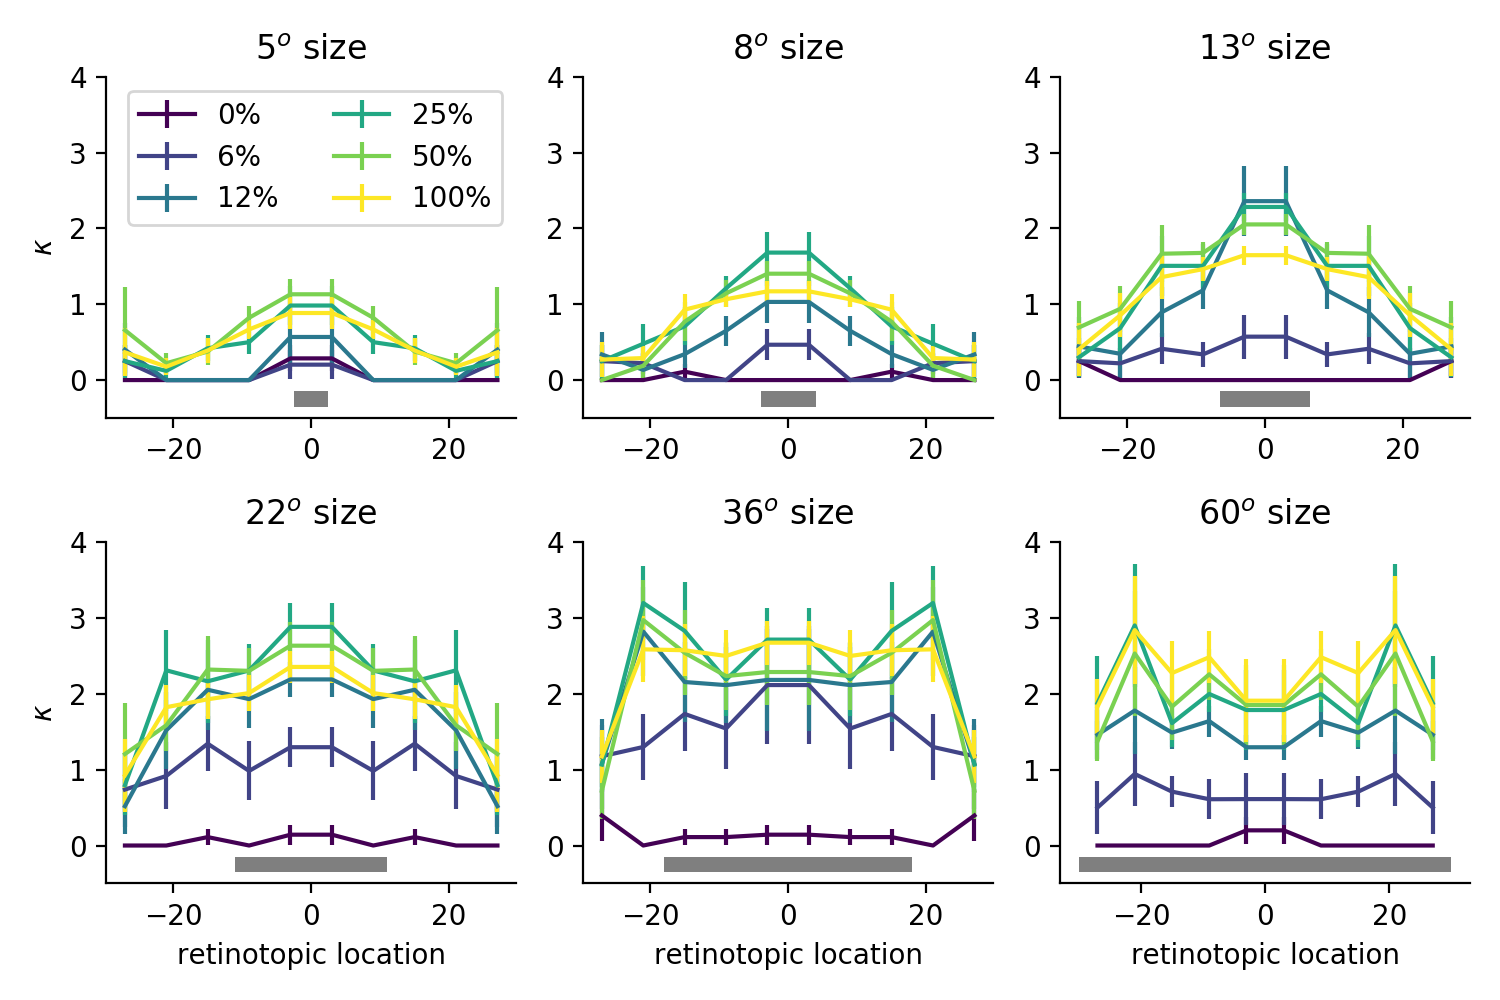

/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the 

In [28]:
colors = plt.cm.viridis(np.linspace(0,1,6))
x = 0.5*(bins[1:]+bins[:-1])
x = np.concatenate((-x[::-1],x))
plt.figure(figsize=(7.5,5))
for isize in range(nsize):
    plt.subplot(2,3,isize+1)
    for icontrast in range(0,ncontrast):
        lkat = data_n[:,:,isize,icontrast]
        data = np.nanmean(kappa_bin[:,:,isize,icontrast],0)
        data = np.concatenate((data[::-1],data))
        this_sem = np.nanstd(kappa_bin[:,:,isize,icontrast],0)/np.sqrt(np.sum(~np.isnan(kappa_bin[:,:,isize,icontrast]),0))
#         this_sem = np.sqrt(np.nansum(osi_sem[:,:,isize,icontrast]**2,0))/np.sum(~np.isnan(data_sem[:,:,isize,icontrast]),0)
        this_sem = np.concatenate((this_sem[::-1],this_sem))
        plt.errorbar(x,data,this_sem,c=colors[icontrast],label='%d%%'%ucontrast[icontrast])
#         plt.plot(x,data,c=colors[icontrast])
    plt.ylim((-0.5,4))
    plt.fill_between((-usize[isize]/2,usize[isize]/2),(-0.35,-0.35),(-0.15,-0.15),facecolor='k',alpha=0.5)
    plt.title('%d$^o$ size'%usize[isize])
    ut.erase_top_right()
#     plt.axhline(0,c='k',linestyle='dashed',alpha=0.5)
for iplot in range(3,6):
    plt.subplot(2,3,iplot+1)
    plt.xlabel('retinotopic location')
for iplot in range(0,6,3):
    plt.subplot(2,3,iplot+1)
    plt.ylabel(r'$\kappa$')
plt.subplot(2,3,1)
plt.legend(ncol=2)
plt.tight_layout()
# plt.savefig('figures/spatial_kappa_by_size.jpg',dpi=300)

<IPython.core.display.Javascript object>


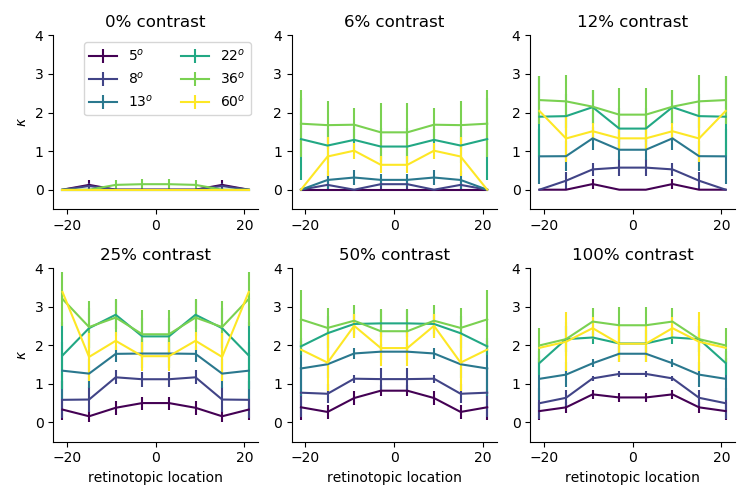

/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently

In [401]:
colors = plt.cm.viridis(np.linspace(0,1,6))
x = 0.5*(bins[1:]+bins[:-1])
x = np.concatenate((-x[::-1],x))
plt.figure(figsize=(7.5,5))
for isize in range(nsize):
    for icontrast in range(0,ncontrast):
        plt.subplot(2,3,icontrast+1)
        lkat = data_n[:,:,isize,icontrast]
        data = np.nanmean(kappa_bin[:,:,isize,icontrast],0)
        data = np.concatenate((data[::-1],data))
        this_sem = np.nanstd(kappa_bin[:,:,isize,icontrast],0)/np.sqrt(np.sum(~np.isnan(kappa_bin[:,:,isize,icontrast]),0))
#         this_sem = np.sqrt(np.nansum(osi_sem[:,:,isize,icontrast]**2,0))/np.sum(~np.isnan(data_sem[:,:,isize,icontrast]),0)
        this_sem = np.concatenate((this_sem[::-1],this_sem))
        plt.errorbar(x,data,this_sem,c=colors[isize],label='%d$^o$'%usize[isize])
#         plt.plot(x,data,c=colors[icontrast])
        plt.ylim((-0.5,4))
#     plt.fill_between((-usize[isize]/2,usize[isize]/2),(-0.35,-0.35),(-0.15,-0.15),facecolor='k',alpha=0.5)
        plt.title('%d%% contrast'%ucontrast[icontrast])
        ut.erase_top_right()
for iplot in range(3,6):
    plt.subplot(2,3,iplot+1)
    plt.xlabel('retinotopic location')
for iplot in range(0,6,3):
    plt.subplot(2,3,iplot+1)
    plt.ylabel(r'$\kappa$')
plt.subplot(2,3,1)
plt.legend(ncol=2)
plt.tight_layout()
# plt.savefig('figures/spatial_kappa_by_contrast.jpg',dpi=300)

In [29]:
N = 100000
osi_dist = ut.compute_osi(np.exp(np.random.randn(N,8))[:,:,np.newaxis],np.arange(0,360,45))

<IPython.core.display.Javascript object>


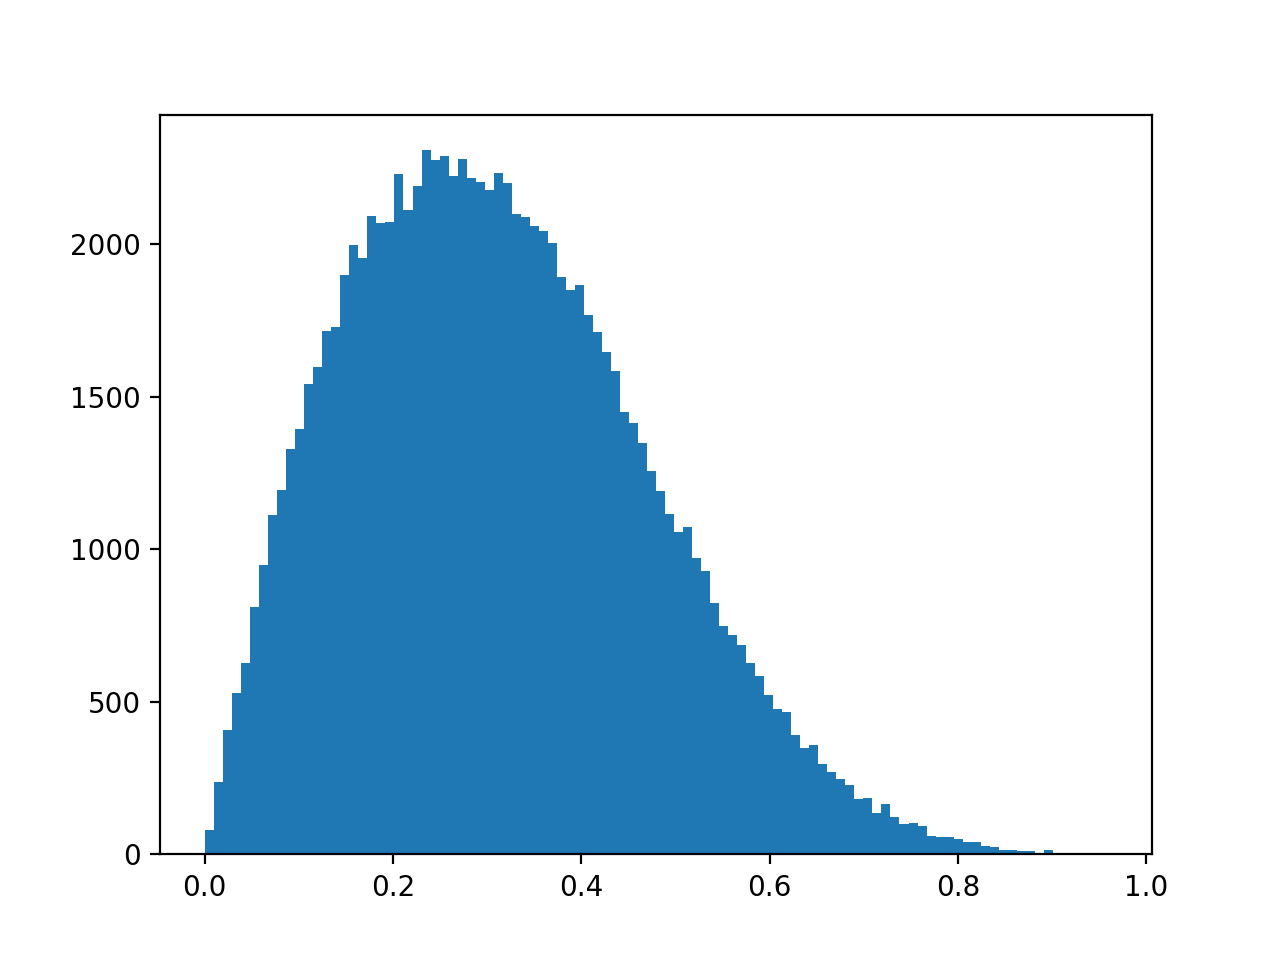

(array([8.100e+01, 2.370e+02, 4.070e+02, 5.300e+02, 6.270e+02, 8.120e+02,
        9.490e+02, 1.113e+03, 1.195e+03, 1.327e+03, 1.393e+03, 1.542e+03,
        1.597e+03, 1.716e+03, 1.728e+03, 1.899e+03, 1.997e+03, 1.954e+03,
        2.093e+03, 2.069e+03, 2.072e+03, 2.229e+03, 2.113e+03, 2.190e+03,
        2.307e+03, 2.276e+03, 2.288e+03, 2.223e+03, 2.278e+03, 2.217e+03,
        2.203e+03, 2.177e+03, 2.233e+03, 2.200e+03, 2.098e+03, 2.090e+03,
        2.060e+03, 2.043e+03, 2.002e+03, 1.892e+03, 1.848e+03, 1.867e+03,
        1.768e+03, 1.712e+03, 1.646e+03, 1.585e+03, 1.449e+03, 1.413e+03,
        1.347e+03, 1.257e+03, 1.190e+03, 1.117e+03, 1.058e+03, 1.073e+03,
        9.700e+02, 9.300e+02, 8.250e+02, 7.480e+02, 7.190e+02, 6.860e+02,
        6.280e+02, 5.850e+02, 5.230e+02, 4.780e+02, 4.660e+02, 3.900e+02,
        3.500e+02, 3.600e+02, 2.950e+02, 2.710e+02, 2.470e+02, 2.270e+02,
        1.820e+02, 1.850e+02, 1.350e+02, 1.650e+02, 1.230e+02, 9.900e+01,
        1.020e+02, 9.300e+01, 6.000e+0

In [30]:
plt.figure()
plt.hist(osi_dist,bins=100)

In [156]:
angles = np.arange(0,360,45)

/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


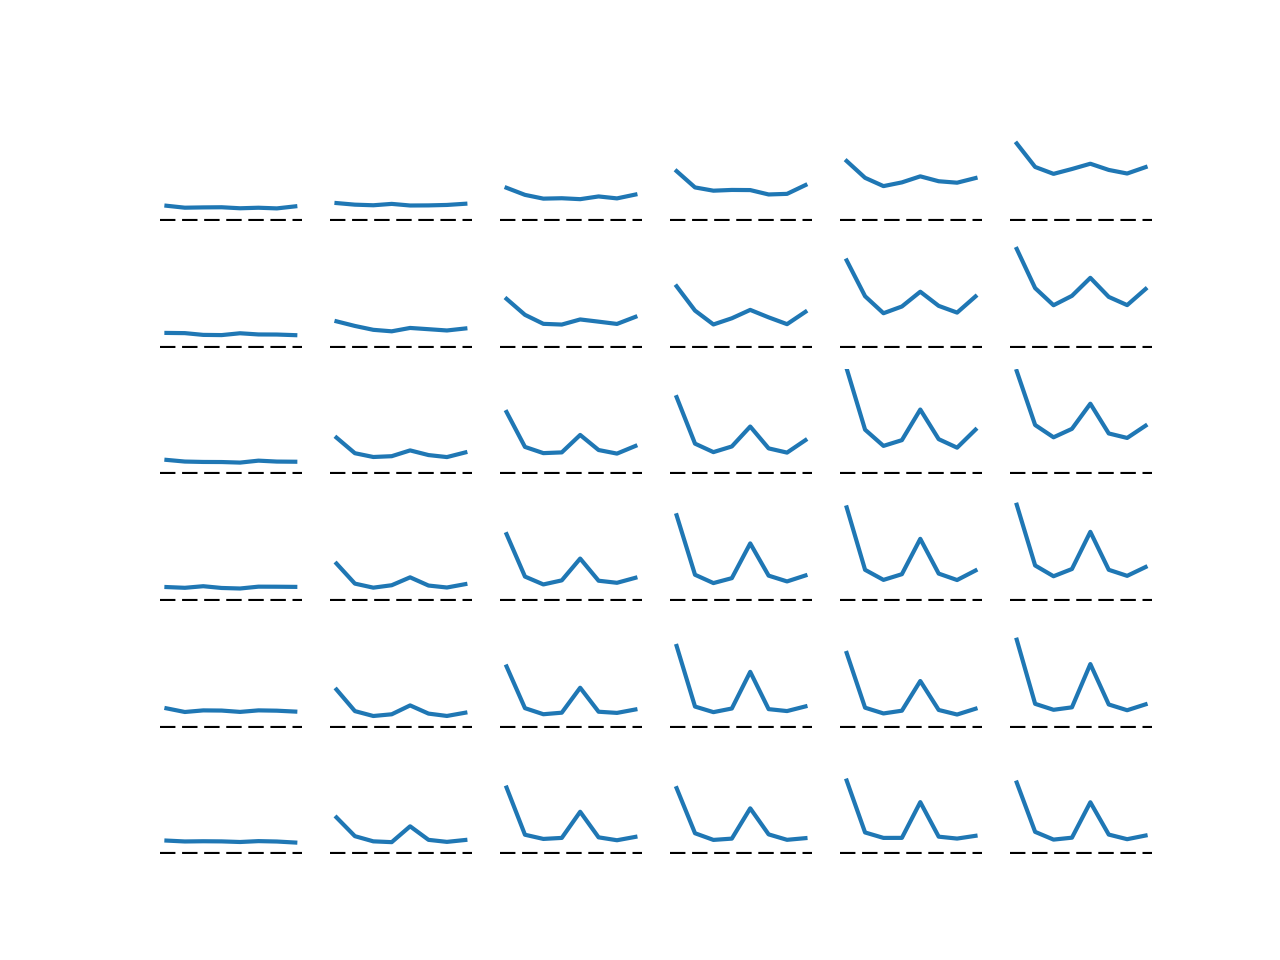

In [157]:
plt.figure()
this_data = np.nanmean(ori_data,0)
for isize in range(nsize):
    for icontrast in range(ncontrast):
        plt.subplot(nsize,ncontrast,isize*ncontrast+icontrast+1)
        plt.plot(this_data[isize,icontrast])
        plt.ylim((0,this_data.max()))
        plt.axhline(0,c='k',linestyle='dashed')
        plt.axis('off')

/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


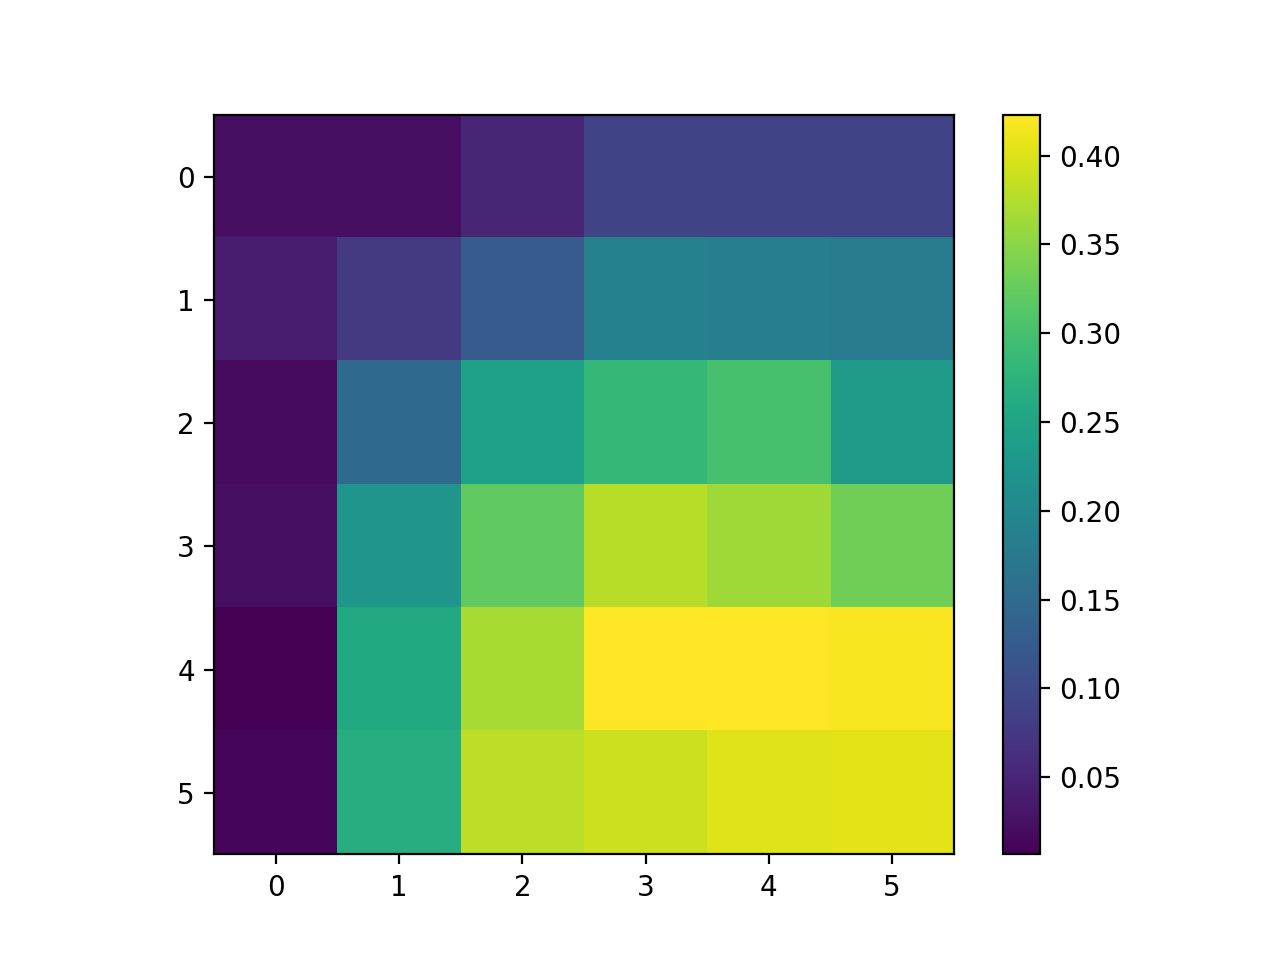

In [160]:
plt.figure()
this_osi = ut.compute_osi(this_data[:,:,:,np.newaxis],angles)[:,:,0]
plt.imshow(this_osi)
plt.colorbar()

In [158]:
plt.figure()
this_kappa = np.zeros((nsize,ncontrast))
for isize in range(nsize):
    for icontrast in range(ncontrast):
        this_kappa[isize,icontrast] = optimize_kappa(this_data[isize,icontrast,:],cost_fn=svm_cost_l1,args=(l1_lambda,))
plt.imshow(this_kappa)
plt.colorbar()

/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>

/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


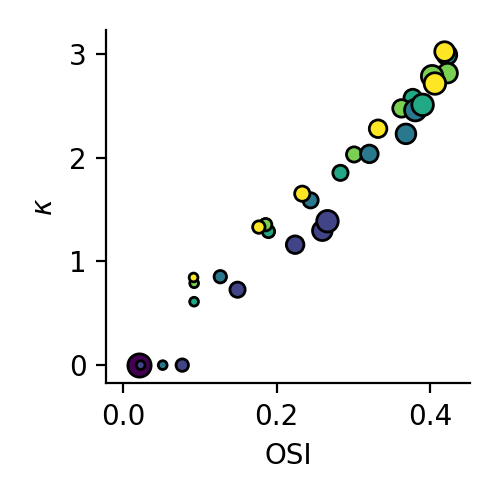

In [161]:
plt.figure(figsize=(2.5,2.5))
sca.scatter_size_contrast(this_osi,this_kappa,square=False,equality_line=False,equate_0=True)
ut.erase_top_right()
plt.xlabel('OSI')
plt.ylabel(r'$\kappa$')
plt.tight_layout()
# plt.savefig('figures/osi_vs_kappa.eps')

In [172]:
k0 = 0.08
s0 = 20
a = 1
modeled_kappa = k0**2/(1/s0**2 + 1/(a*usize)**2)

/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


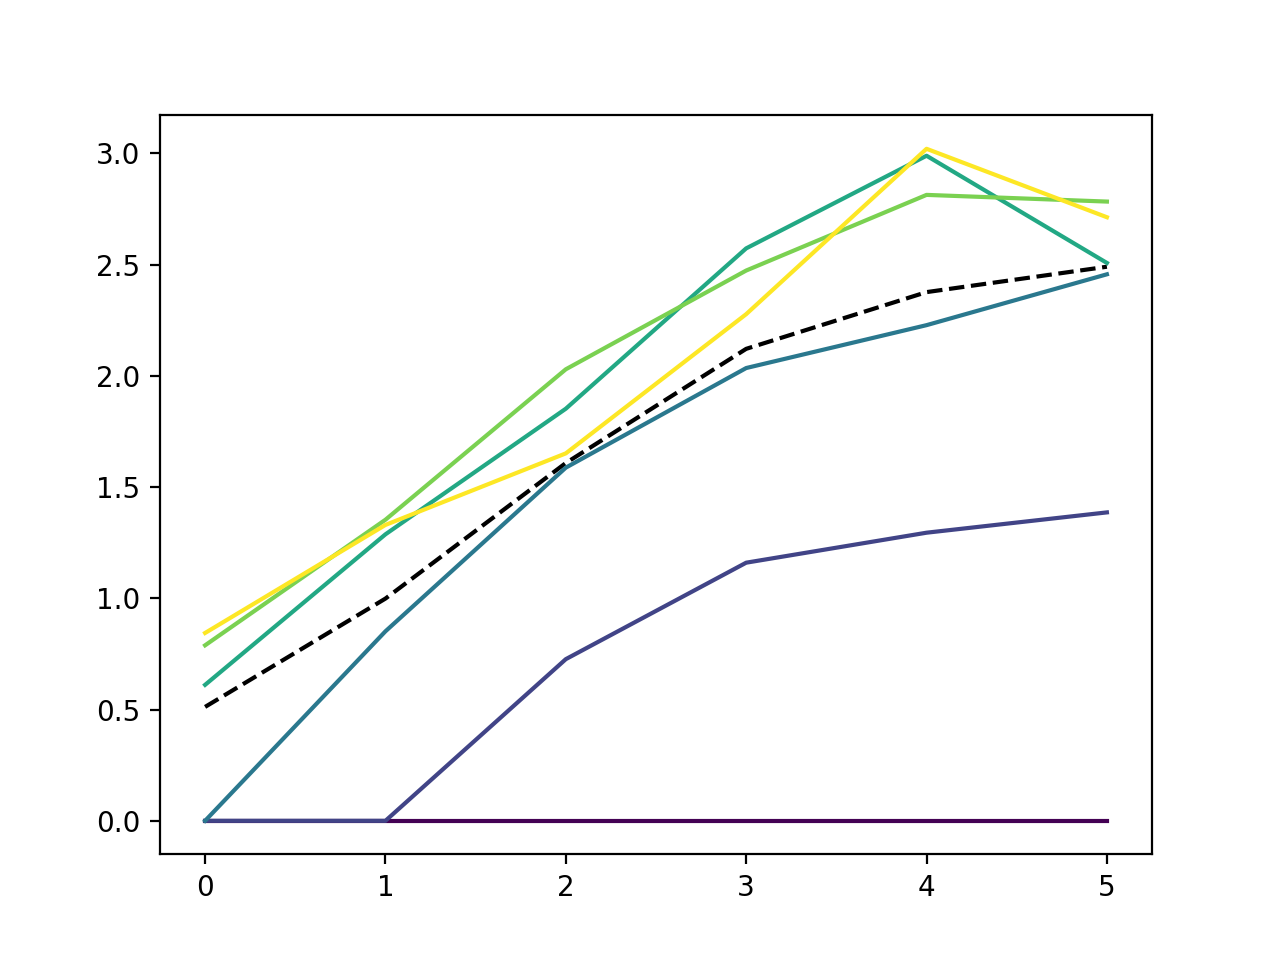

In [173]:
plt.figure()
plt.plot(modeled_kappa,c='k',linestyle='dashed')
for icontrast in range(ncontrast):
    plt.plot(this_kappa[:,icontrast],c=colors[icontrast])

In [37]:
ncutoff = 1
nsize,ncontrast,nangle = 6,6,8
irun,itype,ialign = 0,0,0
nexpt = len(ret_info[0][0])
bins = np.linspace(0,30,6)
nbin = len(bins)-1
l1_lambda = 5e-5
rf_cutoff = 7.5
data_bin,data_sem,osi_bin,kappa_bin,data_n = [[None,None] for ivar in range(5)]
for irf in range(2):
    data_bin[irf] = np.nan*np.ones((nexpt,nbin,nsize,ncontrast))
    data_sem[irf] = np.nan*np.ones((nexpt,nbin,nsize,ncontrast))
    osi_bin[irf] = np.nan*np.ones((nexpt,nbin,nsize,ncontrast))
    kappa_bin[irf] = np.nan*np.ones((nexpt,nbin,nsize,ncontrast))
    data_n[irf] = np.nan*np.ones((nexpt,nbin,nsize,ncontrast))
    for iexpt in range(nexpt):
        if not ret_info[0][0][iexpt]['ret_map_loc'] is None and not tunings_decon[0][0][iexpt] is None:
    #         distance = np.sqrt(np.sum(ret_info[0][0][iexpt]['ret_map_loc']**2,1))
            distance = np.sqrt(np.sum(ret_info[0][0][iexpt]['rf_center']**2,1))
            this_data = np.nanmean(tunings_decon[0][0][iexpt][:,:,[0,-5,-4,-3,-2,-1],:,8:-8],4)
            data = np.nanmean(this_data,3)
    #         osi_data = ut.compute_osi(this_data[:,:,:,:,np.newaxis],np.arange(0,360,45))[:,:,:,0]
    # 
    #         data = np.nanmean(rs[irun][itype][ialign][(expt_ids[irun][itype][ialign]==iexpt)],3)
            data = data/np.nanmean(data)
            ori_data = ut.circ_align_to_pref(this_data,axis=3)
    #         osi_data[np.isnan(osi_data)] = 0
    #         ori_data[np.isnan(ori_data)] = 0
    #         data = data/np.nanmean(np.nanmean(data,1),1)[:,np.newaxis,np.newaxis]
            non_nan = ~np.isnan(np.nanmean(np.nanmean(data,1),1)) #& ~np.isnan(np.nanmean(np.nanmean(np.nanmean(ori_data,1),1),1))
            sig_driven = (ret_info[0][0][iexpt]['pval'] < 0.05) & (ret_info[0][0][iexpt]['amplitude'] > 0) & (ret_info[0][0][iexpt]['sigma'] > 3.3) & (ret_info[0][0][iexpt]['sqerror'] < 0.5) & (ret_info[0][0][iexpt]['sigma'] < 10)
            big_rf = (ret_info[0][0][iexpt]['sigma'] > rf_cutoff)
            if irf==0:
                lkat = non_nan & sig_driven & ~big_rf
            else:
                lkat = non_nan & sig_driven & big_rf
                print(lkat.sum())
            this_nsize = data.shape[1]
            if np.sum(lkat):
                for isize in range(this_nsize):
                    for icontrast in range(ncontrast):
                        data_bin[irf][iexpt,:,isize,icontrast] = sst.binned_statistic(distance[lkat],data[lkat,isize,icontrast],statistic=np.nanmean,bins=bins).statistic
                        data_sem[irf][iexpt,:,isize,icontrast] = sst.binned_statistic(distance[lkat],data[lkat,isize,icontrast],statistic=nansem,bins=bins).statistic
                        ori_data_bin = np.zeros((nangle,nbin))
                        for iangle in range(nangle):
                            this_lkat = ~np.isnan(ori_data[lkat,isize,icontrast,iangle])
                            this_ori_data = ori_data[lkat,isize,icontrast,iangle][this_lkat]
                            this_distance = distance[lkat][this_lkat]
                            ori_data_bin[iangle] = sst.binned_statistic(this_distance,this_ori_data,statistic=np.nanmean,bins=bins).statistic
                        osi_bin[irf][iexpt,:,isize,icontrast] = ut.compute_osi(ori_data_bin,uangle)[0]
                        for ibin in range(nbin):
                            kappa_bin[irf][iexpt,ibin,isize,icontrast] = optimize_kappa(ori_data_bin[:,ibin],cost_fn=svm_cost_l1,args=(l1_lambda,))
    #                     osi_bin[iexpt,:,isize,icontrast] = sst.binned_statistic(distance[lkat],osi_data[lkat,isize,icontrast],statistic=np.nanmean,bins=bins).statistic
    #                     osi_sem[iexpt,:,isize,icontrast] = sst.binned_statistic(distance[lkat],osi_data[lkat,isize,icontrast],statistic=nansem,bins=bins).statistic
                        data_n[irf][iexpt,:,isize,icontrast] = sst.binned_statistic(distance[lkat],data[lkat,isize,icontrast],statistic=n_non_nan,bins=bins).statistic
    data_bin[irf][data_n[irf] < ncutoff] = np.nan
    data_sem[irf][data_n[irf] < ncutoff] = np.nan
    osi_bin[irf][data_n[irf] < ncutoff] = np.nan
    kappa_bin[irf][data_n[irf] < ncutoff] = np.nan
    data_bin[irf][:,:,:,:] = data_bin[irf][:,:,:,:]-data_bin[irf][:,:,:,0:1]

/Users/dan/Documents/code/adesnal/pyute.py:1825: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  data_aligned[iroi] = data[iroi][slicer]
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in less
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: Mean of empty slice
  return f_raw(*args, **kwargs)
/Users/dan/Documents/code/adesnal/pyute.py:1825: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  data_aligned[iroi] = data[iroi][slicer]
/op

/opt/anaconda3/envs/py3/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: All-NaN slice encountered
  return f_raw(*args, **kwargs)
/Users/dan/Documents/code/adesnal/pyute.py:1825: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  data_aligned[iroi] = data[iroi][slicer]
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in less
/Users/dan/Documents/code/adesnal/pyute.py:1825: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  data_aligned[iroi] = data[iroi][slice

0
189


/opt/anaconda3/envs/py3/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: Mean of empty slice
  return f_raw(*args, **kwargs)
/Users/dan/Documents/code/adesnal/pyute.py:1825: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  data_aligned[iroi] = data[iroi][slicer]
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in less
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: All-NaN slice encountered
  return f_raw(*args, **kwargs)
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: All-NaN slice encountered
  return f_raw(*args, **kwargs)
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/autograd/tracer.

118


/opt/anaconda3/envs/py3/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: All-NaN slice encountered
  return f_raw(*args, **kwargs)
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: All-NaN slice encountered
  return f_raw(*args, **kwargs)
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: All-NaN slice encountered
  return f_raw(*args, **kwargs)
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: All-NaN slice encountered
  return f_raw(*args, **kwargs)
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: All-NaN slice encountered
  return f_raw(*args, **kwargs)
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: All-NaN slice encountered
  return f_raw(*args, **kwargs)
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: All-NaN slice e

83


/opt/anaconda3/envs/py3/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: All-NaN slice encountered
  return f_raw(*args, **kwargs)
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: All-NaN slice encountered
  return f_raw(*args, **kwargs)
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: All-NaN slice encountered
  return f_raw(*args, **kwargs)
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: All-NaN slice encountered
  return f_raw(*args, **kwargs)
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: All-NaN slice encountered
  return f_raw(*args, **kwargs)
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: All-NaN slice encountered
  return f_raw(*args, **kwargs)
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: All-NaN slice e

24


/Users/dan/Documents/code/adesnal/pyute.py:1825: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  data_aligned[iroi] = data[iroi][slicer]
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in less
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: All-NaN slice encountered
  return f_raw(*args, **kwargs)
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: All-NaN slice encountered
  return f_raw(*args, **kwargs)
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: All-NaN slice encountered
  return f_raw(*args, **kwargs)
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/autograd/t

148


/opt/anaconda3/envs/py3/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: All-NaN slice encountered
  return f_raw(*args, **kwargs)
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: All-NaN slice encountered
  return f_raw(*args, **kwargs)
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: All-NaN slice encountered
  return f_raw(*args, **kwargs)
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: All-NaN slice encountered
  return f_raw(*args, **kwargs)
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: All-NaN slice encountered
  return f_raw(*args, **kwargs)
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: All-NaN slice encountered
  return f_raw(*args, **kwargs)
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: All-NaN slice e

109


/Users/dan/Documents/code/adesnal/pyute.py:1825: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  data_aligned[iroi] = data[iroi][slicer]
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in less
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: All-NaN slice encountered
  return f_raw(*args, **kwargs)
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: All-NaN slice encountered
  return f_raw(*args, **kwargs)
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: All-NaN slice encountered
  return f_raw(*args, **kwargs)
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/autograd/t

19


/opt/anaconda3/envs/py3/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: All-NaN slice encountered
  return f_raw(*args, **kwargs)
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: All-NaN slice encountered
  return f_raw(*args, **kwargs)
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: All-NaN slice encountered
  return f_raw(*args, **kwargs)
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: All-NaN slice encountered
  return f_raw(*args, **kwargs)
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: All-NaN slice encountered
  return f_raw(*args, **kwargs)
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: All-NaN slice encountered
  return f_raw(*args, **kwargs)
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: All-NaN slice e

68


/Users/dan/Documents/code/adesnal/pyute.py:1825: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  data_aligned[iroi] = data[iroi][slicer]


153


/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in less
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in less
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in less
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in less


<IPython.core.display.Javascript object>


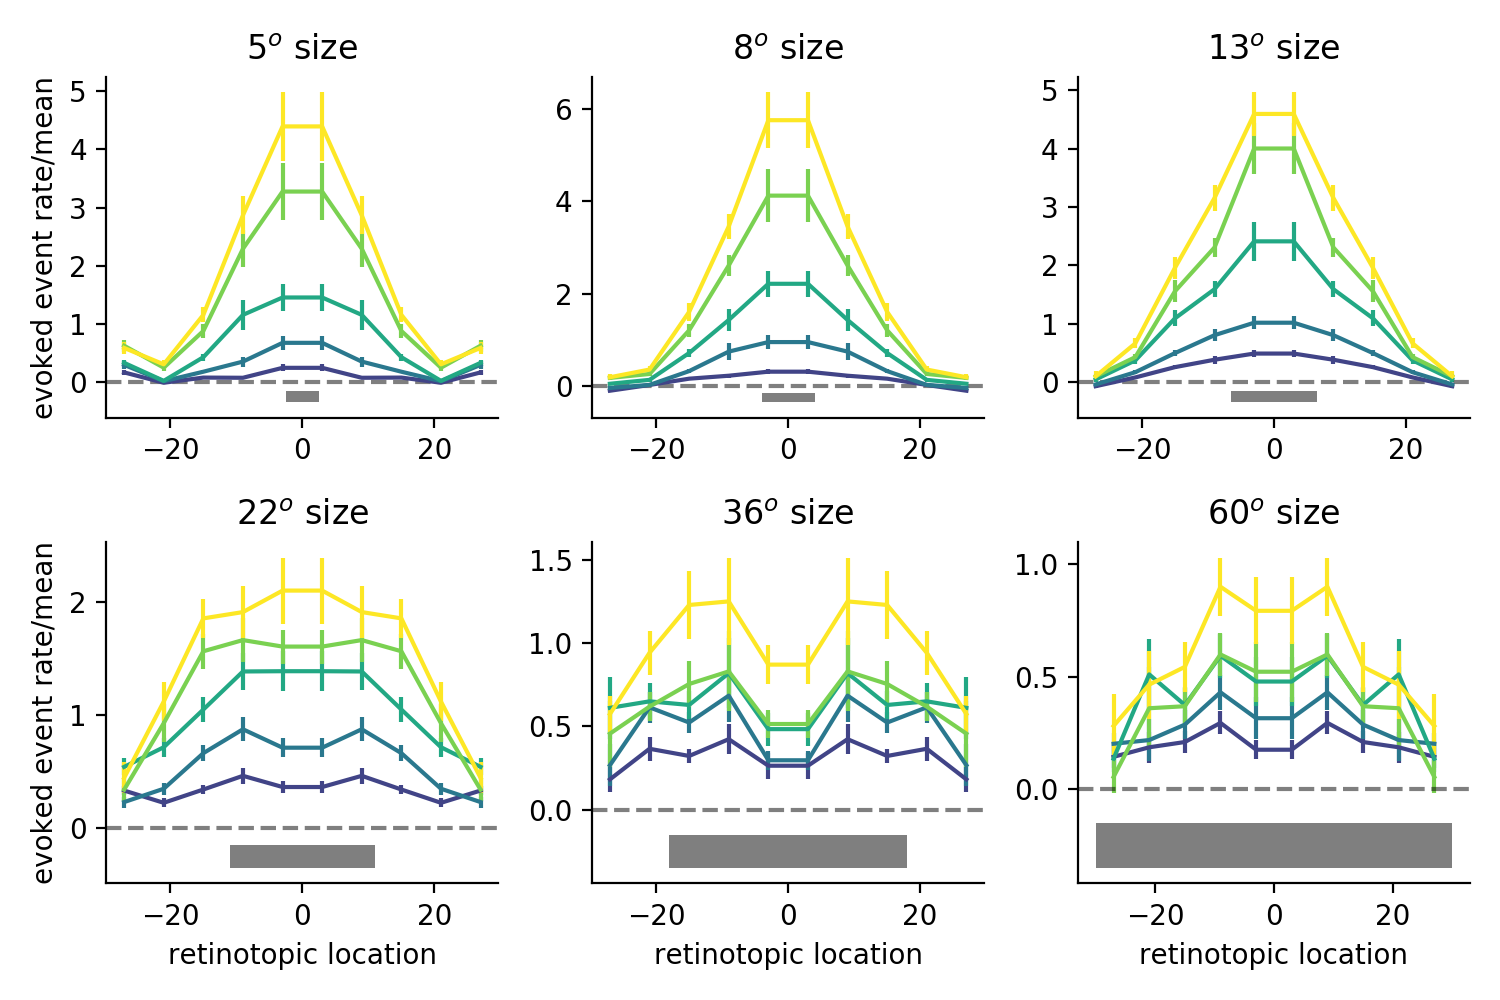

/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the 

<IPython.core.display.Javascript object>


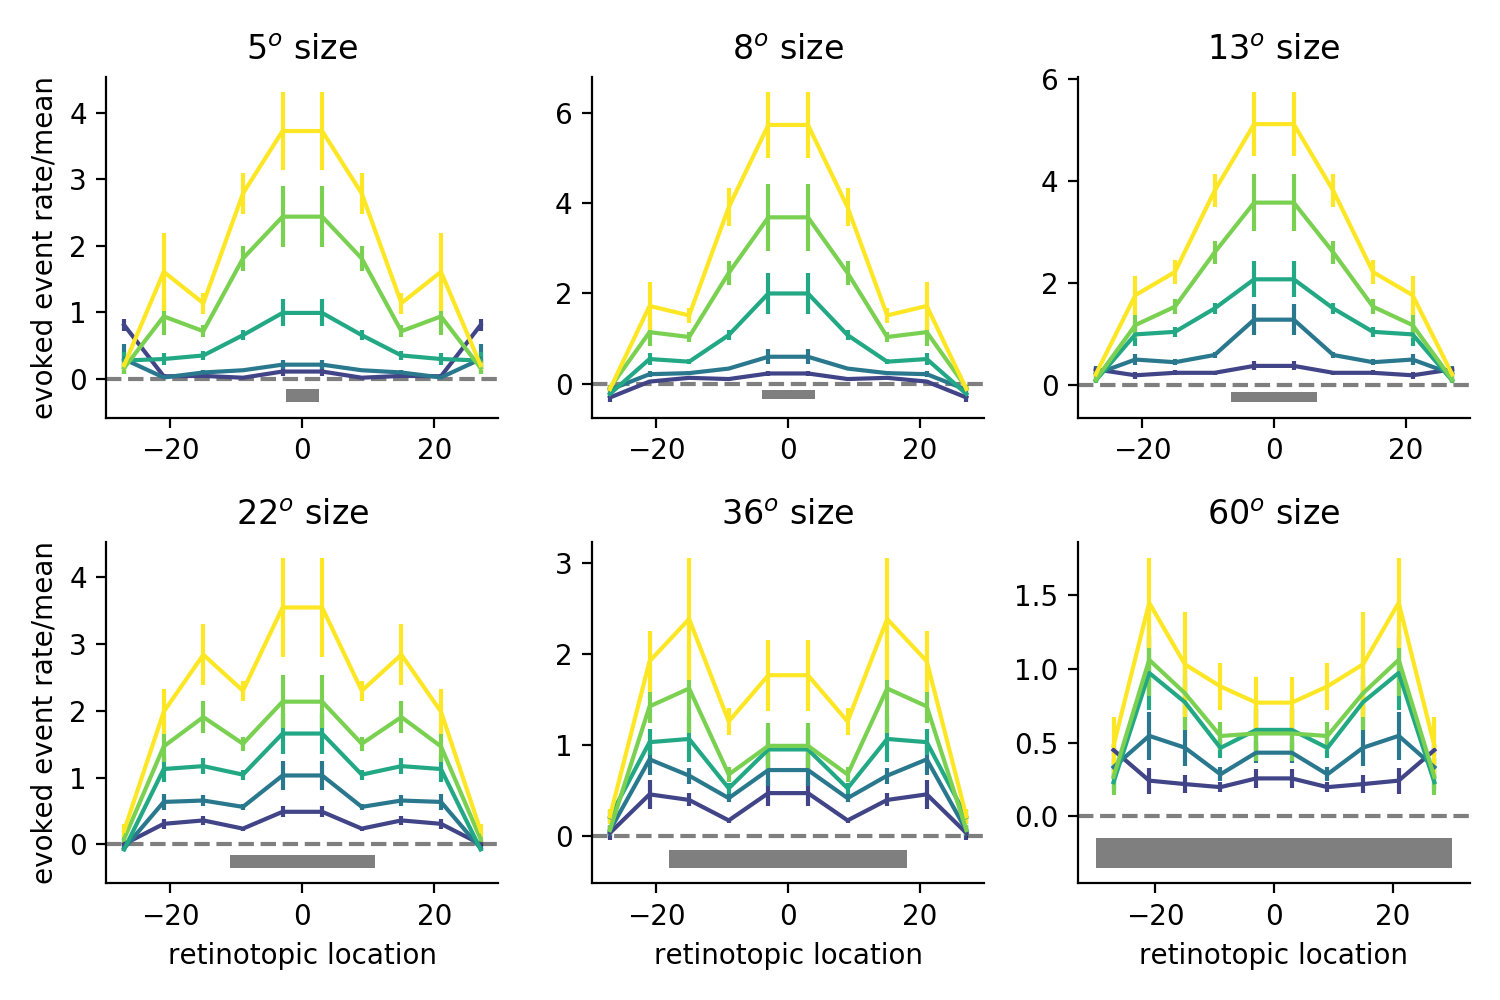

In [38]:
for irf in range(2):
    colors = plt.cm.viridis(np.linspace(0,1,6))
    x = 0.5*(bins[1:]+bins[:-1])
    x = np.concatenate((-x[::-1],x))
    plt.figure(figsize=(7.5,5))
    for isize in range(nsize):
        plt.subplot(2,3,isize+1)
        for icontrast in range(1,ncontrast):
            lkat = data_n[irf][:,:,isize,icontrast]
            data = np.nanmean(data_bin[irf][:,:,isize,icontrast],0)
            data = np.concatenate((data[::-1],data))
            this_sem = np.sqrt(np.nansum(data_sem[irf][:,:,isize,icontrast]**2,0))/np.sum(~np.isnan(data_sem[irf][:,:,isize,icontrast]),0)
            this_sem = np.concatenate((this_sem[::-1],this_sem))
            plt.errorbar(x,data,this_sem,c=colors[icontrast],label='%d%%'%ucontrast[icontrast])
    #     plt.ylim((-0.5,6))
        plt.fill_between((-usize[isize]/2,usize[isize]/2),(-0.35,-0.35),(-0.15,-0.15),facecolor='k',alpha=0.5)
        ut.erase_top_right()
        plt.title('%d$^o$ size'%usize[isize])
        plt.axhline(0,c='k',linestyle='dashed',alpha=0.5)
    for iplot in range(3,6):
        plt.subplot(2,3,iplot+1)
        plt.xlabel('retinotopic location')
    for iplot in range(0,6,3):
        plt.subplot(2,3,iplot+1)
        plt.ylabel('evoked event rate/mean')
    plt.subplot(2,3,6)
    # plt.legend(ncol=2)
    plt.tight_layout()
    # plt.savefig('figures/spatial_evoked_by_size_diff_y.jpg',dpi=300)

<IPython.core.display.Javascript object>


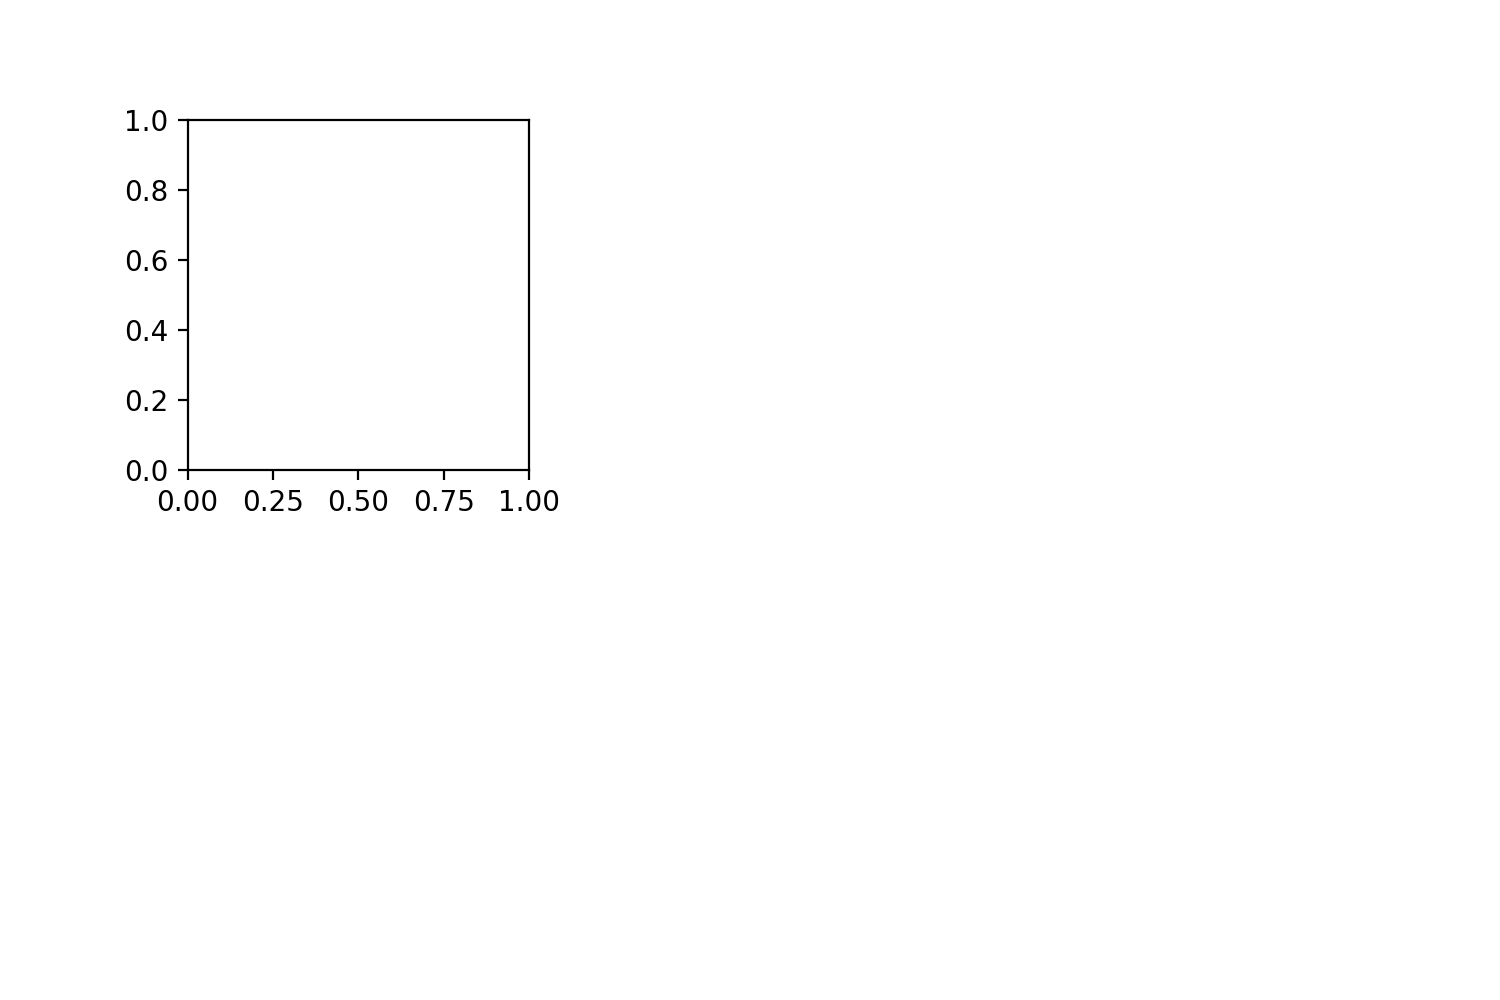

IndexError: too many indices for array

In [36]:
for irf in range(2):
    colors = plt.cm.viridis(np.linspace(0,1,6))
    x = 0.5*(bins[1:]+bins[:-1])
    x = np.concatenate((-x[::-1],x))
    plt.figure(figsize=(7.5,5))
    for isize in range(nsize):
        plt.subplot(2,3,isize+1)
        for icontrast in range(0,ncontrast):
            lkat = data_n[irf][:,:,isize,icontrast]
            data = np.nanmean(kappa_bin[irf][:,:,isize,icontrast],0)
            data = np.concatenate((data[::-1],data))
            this_sem = np.nanstd(kappa_bin[irf][:,:,isize,icontrast],0)/np.sqrt(np.sum(~np.isnan(kappa_bin[irf][:,:,isize,icontrast]),0))
    #         this_sem = np.sqrt(np.nansum(osi_sem[:,:,isize,icontrast]**2,0))/np.sum(~np.isnan(data_sem[:,:,isize,icontrast]),0)
            this_sem = np.concatenate((this_sem[::-1],this_sem))
            plt.errorbar(x,data,this_sem,c=colors[icontrast],label='%d%%'%ucontrast[icontrast])
    #         plt.plot(x,data,c=colors[icontrast])
        plt.ylim((-0.5,4))
        plt.fill_between((-usize[isize]/2,usize[isize]/2),(-0.35,-0.35),(-0.15,-0.15),facecolor='k',alpha=0.5)
        plt.title('%d$^o$ size'%usize[isize])
        ut.erase_top_right()
    #     plt.axhline(0,c='k',linestyle='dashed',alpha=0.5)
    for iplot in range(3,6):
        plt.subplot(2,3,iplot+1)
        plt.xlabel('retinotopic location')
    for iplot in range(0,6,3):
        plt.subplot(2,3,iplot+1)
        plt.ylabel(r'$\kappa$')
    plt.subplot(2,3,1)
    plt.legend(ncol=2)
    plt.tight_layout()
    # plt.savefig('figures/spatial_kappa_by_size.jpg',dpi=300)

<IPython.core.display.Javascript object>


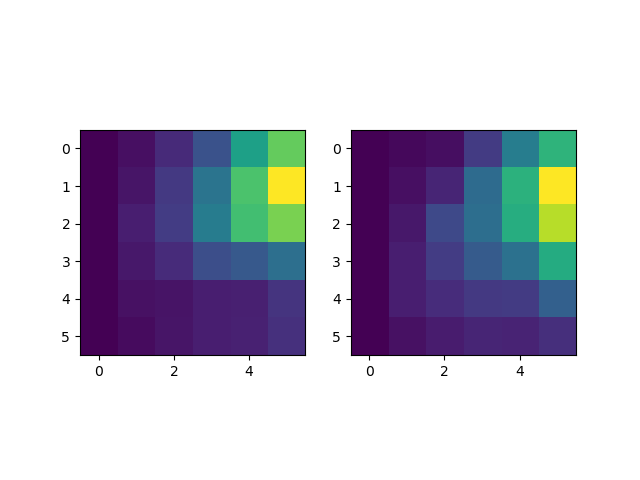

<IPython.core.display.Javascript object>


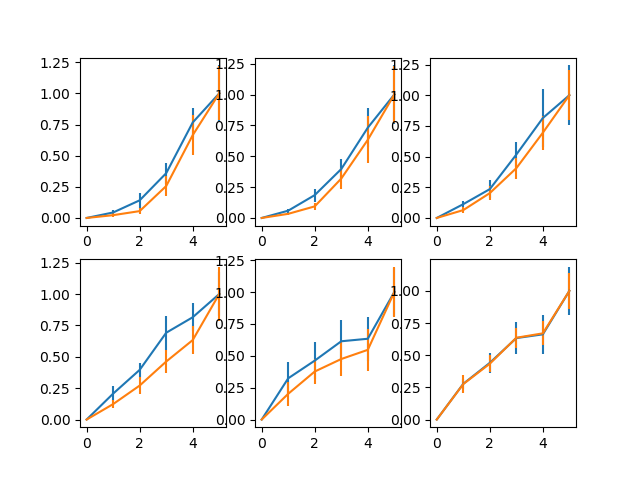

In [506]:
plt.figure()
for irf in range(2):
    plt.subplot(1,2,irf+1)
    plt.imshow(np.nanmean(data_bin[irf],0)[0])
plt.figure()
for isize in range(6):
    plt.subplot(2,3,isize+1)
    for irf in range(2):
        to_plot = np.nanmean(data_bin[irf][:,:2],1)[:,isize]
        mn_to_plot = np.nanmean(to_plot,0)
        sem_to_plot = np.nanstd(to_plot,0)/np.sqrt(np.sum(np.isnan(to_plot),0))
        plt.errorbar(np.arange(6),mn_to_plot/mn_to_plot.max(),sem_to_plot/mn_to_plot.max())

<IPython.core.display.Javascript object>


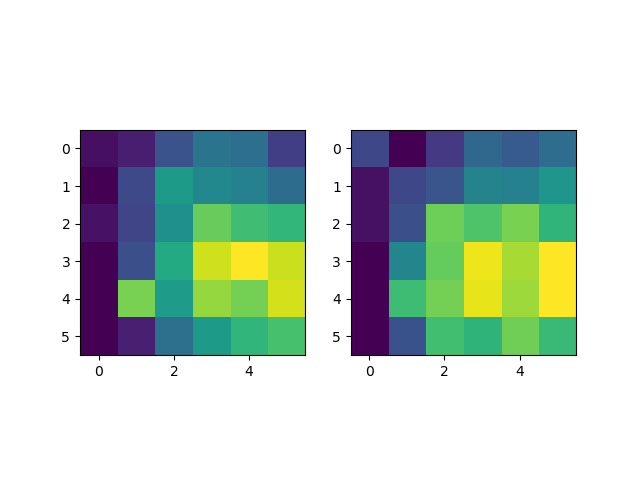

<IPython.core.display.Javascript object>


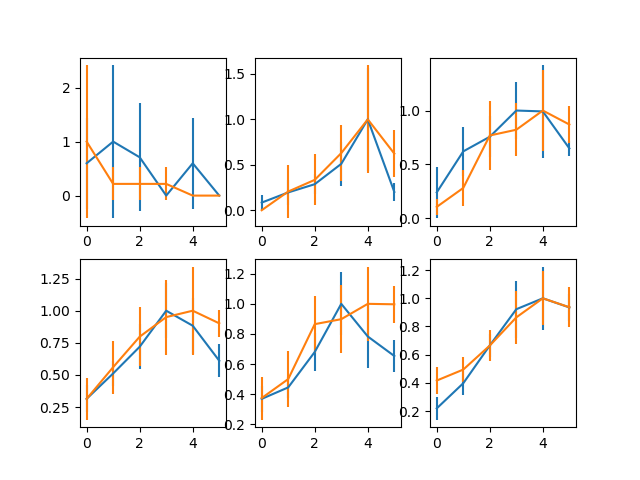

In [508]:
plt.figure()
for irf in range(2):
    plt.subplot(1,2,irf+1)
    plt.imshow(np.nanmean(kappa_bin[irf],0)[0])
plt.figure()
for icontrast in range(6):
    plt.subplot(2,3,icontrast+1)
    for irf in range(2):
        to_plot = np.nanmean(kappa_bin[irf][:,:2],1)[:,:,icontrast]
        mn_to_plot = np.nanmean(to_plot,0)
        sem_to_plot = np.nanstd(to_plot,0)/np.sqrt(np.sum(np.isnan(to_plot),0))
        plt.errorbar(np.arange(6),mn_to_plot/mn_to_plot.max(),sem_to_plot/mn_to_plot.max())

<IPython.core.display.Javascript object>


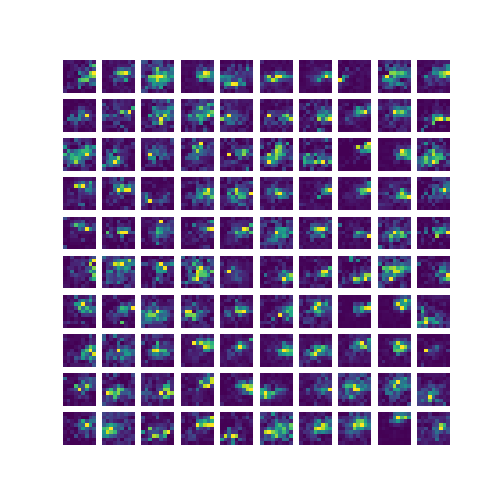

<IPython.core.display.Javascript object>


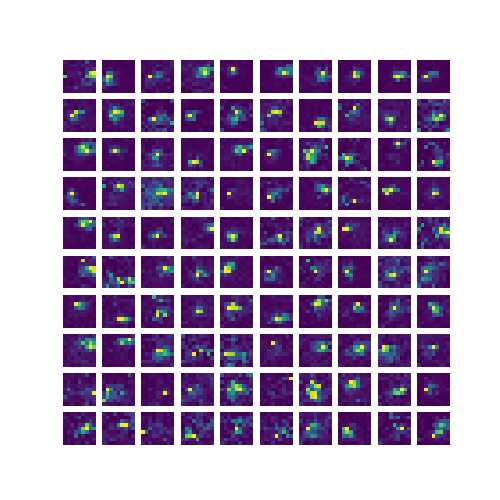

In [470]:
sig_driven = (ret_info[0][0][iexpt]['pval'] < 0.05) & (ret_info[0][0][iexpt]['amplitude'] > 0) & (ret_info[0][0][iexpt]['sigma'] > 2.5) & (ret_info[0][0][iexpt]['sqerror'] < 0.5)
big_rf = (ret_info[0][0][iexpt]['sigma'] > rf_cutoff)
ut.imshow_in_rows(tunings_ret[0][0][iexpt][sig_driven & big_rf][:100,:,:,8:-8].mean(-1))
ut.imshow_in_rows(tunings_ret[0][0][iexpt][sig_driven & ~big_rf][:100,:,:,8:-8].mean(-1))

<IPython.core.display.Javascript object>


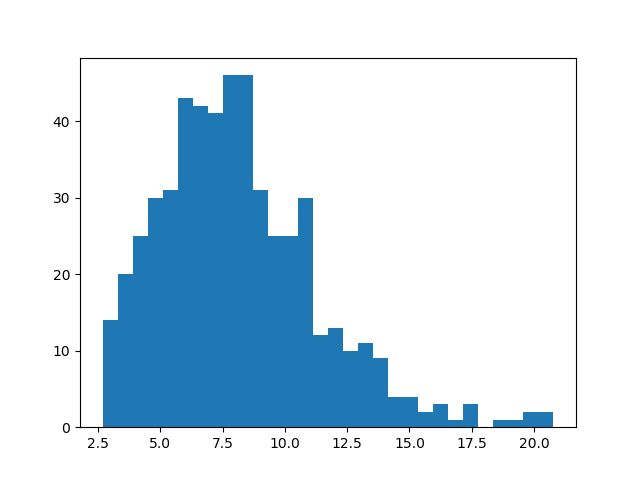

(array([14., 20., 25., 30., 31., 43., 42., 41., 46., 46., 31., 25., 25.,
        30., 12., 13., 10., 11.,  9.,  4.,  4.,  2.,  3.,  1.,  3.,  0.,
         1.,  1.,  2.,  2.]),
 array([ 2.68341791,  3.28651573,  3.88961355,  4.49271138,  5.0958092 ,
         5.69890702,  6.30200484,  6.90510266,  7.50820049,  8.11129831,
         8.71439613,  9.31749395,  9.92059178, 10.5236896 , 11.12678742,
        11.72988524, 12.33298306, 12.93608089, 13.53917871, 14.14227653,
        14.74537435, 15.34847217, 15.95157   , 16.55466782, 17.15776564,
        17.76086346, 18.36396128, 18.96705911, 19.57015693, 20.17325475,
        20.77635257]),
 <a list of 30 Patch objects>)

In [459]:
plt.figure()
plt.hist(ret_info[0][0][iexpt]['sigma'][sig_driven],bins=30)